- [Done] kmeans labels 빼기
- [Done] max_depth 줄이기
- [Done] nunique 높은 cat 없애기
- Catboost 늘려보기
- stacking weiens로 해보기

# Library Setting

In [1]:
import gc
gc.collect()

from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def log_offset(x,verbose=True):
    if min(x)>0:
        offset = 0
    elif min(x)==0:
        offset = 1e-3
    else:
        offset = -min(x)+1e-3
        if verbose:
            print('minimum = {:.3f}'.format(min(x)))
    return np.log(x+offset)

In [3]:
class TypeController:
    def __init__(self,target_feature,cat_features=None,unuse_features=None,segment_feature=None):
        assert type(target_feature).__name__ in ['str'], \
            "target_feature must be 'str'"
        assert type(cat_features).__name__ in ['NoneType','list'], \
            "cat_feature must be 'None' or 'list'"
        assert type(unuse_features).__name__ in ['NoneType','list'], \
            "unuse_features must be 'None' or 'list'"
        assert type(segment_feature).__name__ in ['NoneType','str'], \
            "unuse_features must be 'None' or 'str'"
        
        self.target_feature     = target_feature
        self.fixed_cat_features = [] if cat_features    is None else cat_features
        self.unuse_features     = [] if unuse_features  is None else unuse_features
        self.segment_feature    = [] if segment_feature is None else segment_feature
    
    def _check_dummy(self,data,col):
        return (data[col].nunique()==2) & (sorted(data[col].unique()) == [0,1])
    
    def _check_str(self,data,col):
        try:
            data[col].astype(float)
            dtype = 'float'
        except:
            dtype = 'nan'
        return dtype=='nan'
    
    def _get_feature_type(self,verbose):
        feature_list = ['target_feature','unuse_features','dummy_features','cat_features','num_features','segment_feature']
        if verbose:
            print('> gloval variable assignment')
            
        i=0
        for feature in feature_list:
            i+=1
            if verbose:
                print("[{}] complete: {}".format(i,feature))
            exec("globals()['{}'] = self.{}".format(feature,feature))
    
    def fit(self,data,global_assignment=True,verbose=True) -> None:
        self.cat_features   = []
        self.dummy_features = []
        self.num_features   = []
        
        for col in data.columns:
            if col==self.target_feature:
                pass
            elif col in self.unuse_features:
                pass
            elif col==self.segment_feature:
                pass
            elif col in self.fixed_cat_features:
                self.cat_features.append(col)
            elif self._check_dummy(data,col):
                self.dummy_features.append(col)
            elif self._check_str(data,col):
                self.cat_features.append(col)
            else:
                self.num_features.append(col)
        
        if global_assignment:
            self._get_feature_type(verbose)

    def transform(self,data):
        d = data.copy()
        
        ## (1) unuse_features
        #d.drop(columns=self.unuse_features,inplace=True)
        
        # (2) segment_feature
        d[self.segment_feature] = d[self.segment_feature].astype(str)
        
        # (3) dummy_features
        d[self.dummy_features] = d[self.dummy_features].astype(int)
        
        # (4) cat_features
        d[self.cat_features] = d[self.cat_features].astype(str)
        
        # (5) num_features
        d[self.num_features] = d[self.num_features].astype(float)
        
        return d

<br></br>

# Configuration

In [4]:
class CFG:
    UNUSE_FEATURES = ['ID'] #['ID','판매도시']
    
    SEED = 0
    
    SUBSET_DEPTH = 2
    INTERACTION = False
    FS_ALPHA = 0.01
    
    N_SPLITS = 5
    TARGET_TRANSFORMATION = ['log','sqrt'][0]
    
    LR = 0.01
    EPOCHS = 30000
    ES = 1000
    XGB_LR = 0.01     # default=0.3
    XGB_EPOCHS = 3000 # default=100
    XGB_ES = 100
    XTRATREES_EPOCHS = 100 #default=100

<br></br>

# Data

## Data Load

In [5]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')

In [6]:
train_df.shape, test_df.shape

((57920, 15), (14480, 14))

In [7]:
train_df.head()

,ID,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격
0,TRAIN_00000,2018,2014,skoda,fabia,KAT,SLA,85231,999,0,0,1,0,0,51.74
1,TRAIN_00001,2010,2006,toyota,auris,RKO,SWI,135000,1598,0,0,1,0,0,41.47
2,TRAIN_00002,2002,2002,mercedes-benz,clk-klasa,GNI,WIE,255223,1796,0,0,1,0,0,17.81
3,TRAIN_00003,2006,2001,nissan,x-trail,EHX,WIE,238000,2184,0,1,0,0,0,18.20
4,TRAIN_00004,2007,2007,fiat,bravo,OSW,MAL,251000,1910,0,1,0,0,0,17.55


<br>

## Type Control

In [8]:
type_controller = TypeController(
    target_feature='가격',
    cat_features=None,
    unuse_features=CFG.UNUSE_FEATURES,
    segment_feature=None,
)
type_controller.fit(
    data=train_df,
    global_assignment=True,
    verbose=True,
)

train_df2 = type_controller.transform(train_df)
test_df2  = type_controller.transform(test_df)

> gloval variable assignment
[1] complete: target_feature
[2] complete: unuse_features
[3] complete: dummy_features
[4] complete: cat_features
[5] complete: num_features
[6] complete: segment_feature


In [9]:
cat_features

['브랜드', '차량모델명', '판매도시', '판매구역']

In [10]:
# unuse_feature 제거
train_df.shape, train_df2.shape

((57920, 15), (57920, 15))

<br>

## Target Transformation

In [11]:
if CFG.TARGET_TRANSFORMATION=='log':
    train_df2['가격'] = np.log(train_df2['가격'])
elif CFG.TARGET_TRANSFORMATION=='sqrt':
    train_df2['가격'] = np.sqrt(train_df2['가격'])

<br></br>

# New Features

In [12]:
# pd.Series([str(round(int(year)/100,1)) for year in train_df6['생산년도']]).value_counts()

In [13]:
from tqdm import tqdm
from itertools import chain, combinations

def all_subsets(ss):
    return list(chain(*map(lambda x: combinations(ss, x), range(0, len(ss)+1))))

def has_test_only_value(train,test,group):
    tr_uniques = ['_'.join(x) for x in train[group].drop_duplicates().values]
    te_uniques = ['_'.join(x) for x in test [group].drop_duplicates().values]
    test_only = list(set(te_uniques)-set(tr_uniques))
    _has_test_only = False if len(test_only)==0 else True
    return _has_test_only

def add_fuel_type(data):
    dummy_features = ['압축천연가스(CNG)','액화석유가스(LPG)','경유','가솔린','하이브리드']
    d = data.copy()
    d['fuel_type'] = d[dummy_features].apply(
        lambda x: dummy_features[np.where(x==1)[0][0]],axis=1)
    return d['fuel_type']

def create_production_year_group(data,unknown_value=99999):
    
    ## 브랜드별 year criterion 생성
    # >=기준
    production_year_criterion = [
        ['opel', [2000]],
        ['ford', [2003]],
        ['volkswagen', [1998]],
        ['audi', [1996]],
        ['bmw', [1998]],
        ['renault', [2000]],
        ['toyota', [2003]],
        ['skoda', [None]],
        ['mercedes-benz', [2001]],
        ['nissan', [2003]],
        ['kia', [None]],
        ['hyundai', [2016,2012]],
        ['seat', [2004]],
        ['mazda', [None]],
        ['honda', [None]],
        ['volvo', [None]],
        ['fiat', [None]],
        ['citroen', [None]],
        ['peugeot', [2017]],
        ['mitsubishi', [2007]],
    ]

    ## 브랜드별 year criterion 기준으로 group 생성
    final_data = []
    final_data = []
    for brand, year_criterion in production_year_criterion:
        d = data[data['브랜드']==brand].copy()
        d['production_year_grp'] = unknown_value

        if year_criterion[0] is None:
            d['production_year_grp'] = 0
            final_data.append(d)
        else:
            n = len(year_criterion)
            grp = 0
            for year in year_criterion:
                grp+=1
                d.loc[(d['생산년도']>=year)&(d['production_year_grp']==unknown_value),'production_year_grp'] = grp
                if n==grp:
                    d.loc[(d['생산년도']<year),'production_year_grp'] = grp+1
            final_data.append(d)

    # final concat
    final_data = pd.concat(final_data,axis=0)
    final_data = final_data.sort_index()
    
    return final_data

def segment_count(train,test=None,segment=[]):
    tr_seg_cnt = train.groupby(segment).size().reset_index().rename(columns={0:'tr_cnt'})
    if test is not None:
        te_seg_cnt = test.groupby(segment).size().reset_index().rename(columns={0:'te_cnt'})
        seg_cnt = pd.merge(tr_seg_cnt,te_seg_cnt,how='left',on=segment).fillna(0)
        seg_cnt['cnt_diff'] = seg_cnt['tr_cnt'] - seg_cnt['te_cnt']
        int_cols = ['tr_cnt','te_cnt','cnt_diff']
    else:
        seg_cnt = tr_seg_cnt
        int_cols = ['tr_cnt']
    seg_cnt[int_cols] = seg_cnt[int_cols].astype(int)
    return seg_cnt

# # example)
# train_df3 = create_production_year_group(train_df2)
# test_df3  = create_production_year_group(test_df2)
# segment_count(train_df3,test_df3,['브랜드','production_year_grp'])
# segment_count(train_df3,None,['브랜드','production_year_grp'])

In [14]:
import itertools

class FeatureEngineering:
    def __init__(self):
        pass
    
    def _get_quantile(self,x,col):
        x = np.array(x).flatten()
        x = x[pd.notnull(x)]

        agg_df = pd.DataFrame(index=[0])
        agg_df[f'{col}_Avg'] = np.mean(x)
        for q in [25,50,75]:
            agg_df[f'{col}_Q{q}'] = np.quantile(x,q/100)

        return agg_df
    
    def _derived_features(self,data):
        d = data.copy()

        # (1) 모델출시년도에 생산된 차량인지
        d['출시년도생산여부'] = np.where(d['생산년도'].astype(int)==d['모델출시년도'].astype(int),1,0)

        # (2) 모델출시 이후에 몇년 지나서 생산됬는지
        d['출시이후생산년수'] = d['생산년도'].astype(int)-d['모델출시년도'].astype(int)

        # (3) 출시 이전에 생산되었는지
        d['출시이전생산여부'] = np.where(d['출시이후생산년수']<=0,1,0)

        # (4) 브랜드의 국적 (구글링)
        d['브랜드국적'] = ['체코' if brand=='skoda' else
                        '일본' if brand in ['toyota','nissan','mazda','honda','mitsubishi'] else
                        '독일' if brand in ['mercedes-benz','audi','volkswagen','bmw','opel'] else
                        '이탈리아' if brand=='fiat' else
                        '프랑스' if brand in ['renault','citroen','peugeot'] else
                        '미국' if brand=='ford' else
                        '한국' if brand in ['kia','hyundai'] else
                        '스페인' if brand=='seat' else
                        '스웨덴' if brand=='volvo' else
                        np.nan for brand in d['브랜드']]

        # (5) 브랜드 국적의 대륙명
        d['브랜드대륙명'] = ['유럽' if country in ['체코','독일','이탈리아','프랑스','스페인','스웨덴'] else
                          '아시아' if country in ['일본','한국'] else
                          '아메리카' if country in ['미국'] else
                          np.nan for country in d['브랜드국적']]
        
        # (6) CNG or LPG
        d['가스'] = [np.nan if (cng==np.nan)|(lpg==np.nan) else
                    1 if (cng==1)|(lpg==1) else 
                    0 for cng,lpg in d[['압축천연가스(CNG)','액화석유가스(LPG)']].values]
        d['가스'] = d['가스'].astype('Int64')
        
        # (7) 연료타입
        d['연료타입'] = add_fuel_type(d)
        d.drop(columns=['압축천연가스(CNG)','액화석유가스(LPG)','경유','가솔린','하이브리드'],inplace=True)
        
        # (8) 판매도시구역 동일여부
        d['판매도시구역동일여부'] = np.where(d['판매도시']==d['판매구역'],1,0)
        
        # (9) 배기량 그룹
        bin_size = 100
        d['배기량_grp'] = d['배기량'].values//bin_size*bin_size
        
        return d
    
    # test_data는 test에만 있는 group을 판별 시 사용됨
    # -> 함수 : has_test_only_value(data,test_data,subset)
    def fit(self,data,test_data,target_feature,num_features=[],cat_features=[],dummy_features=[],subset_depth=1):
        assert len(cat_features)>=subset_depth, \
            'len(cat_features) >= subset_depth'
        
        self.data           = data
        self.test_data      = data
        self.target_feature = target_feature
        self.num_features   = num_features
        self.cat_features   = cat_features
        self.dummy_features = dummy_features
        self.subset_depth   = subset_depth
        
        self.original_features = [target_feature]+num_features+cat_features+dummy_features
        
        # (1) 파생변수생성
        data      = self._derived_features(data)
        test_data = self._derived_features(test_data)
        
        # (2) 브랜드별 생산년도기준으로 group 생성
        data      = create_production_year_group(data)
        test_data = create_production_year_group(test_data)
        # segment_count(data,test_data,segment=['브랜드','production_year_grp'])
        
        # (3) 카테고리 변수에 따른 가격의 Quantile값
        all_subset_list = all_subsets(self.cat_features) #+self.new_cat_features
        all_subset_list = [subset for subset in all_subset_list if (len(subset)<=subset_depth) & (len(subset)>=1)]
        print(f'> Get quantiles of target by categorical features (depth={subset_depth})')
        
        self.agg_dict = {}
        pbar = tqdm(all_subset_list)
        for subset in pbar:
            subset = list(subset)
            if has_test_only_value(data,test_data,subset):
                pass
            else:
                pbar.set_description('Subset: {}'.format(' + '.join(subset)))
                subset_name = '_'.join(subset)
                agg_fn = data\
                    .groupby(subset)[self.target_feature]\
                    .apply(lambda x: self._get_quantile(x,subset_name))\
                    .reset_index()
                drop_cols = [col for col in agg_fn if col.find('level_')>=0]
                agg_fn.drop(columns=drop_cols,inplace=True)
                if agg_fn.isnull().sum().sum()>0:
                    print('> Null Detectd: {} -> Passed'.format('+'.join(subset)))
                else:
                    self.agg_dict[subset_name] = agg_fn
                    
        self.deleted_dummy_features = ['압축천연가스(CNG)','액화석유가스(LPG)','경유','가솔린','하이브리드']
        self.new_cat_features       = ['브랜드국적','브랜드대륙명','연료타입','production_year_grp','배기량_grp']
        self.new_dummy_features     = ['출시년도생산여부','출시이전생산여부','가스','판매도시구역동일여부']
        
    def transform(self,data):
        # (1) 파생변수생성
        data = self._derived_features(data)
        
        # (2) 브랜드별 생산년도기준으로 group 생성
        data = create_production_year_group(data)
        
        # (3) 카테고리 변수에 따른 가격의 Quantile값
        for key,agg_fn in self.agg_dict.items():
            data = pd.merge(data,agg_fn,how='left',on=key.split('_'))

        return data
    
    def fit_transform(self,data,test_data,target_feature,num_features=[],cat_features=[],dummy_features=[],subset_depth=1):
        self.fit(data,test_data,target_feature,num_features,cat_features,dummy_features,subset_depth)
        return self.transform(data)

In [15]:
fe = FeatureEngineering()
fe.fit(
    data=train_df2,
    test_data=test_df2,
    target_feature=target_feature,
    num_features=num_features,
    cat_features=cat_features,
    dummy_features=dummy_features,
    subset_depth=CFG.SUBSET_DEPTH,
)
train_df3 = fe.transform(train_df2)
test_df3  = fe.transform(test_df2)

> Get quantiles of target by categorical features (depth=2)


Subset: 브랜드 + 판매구역: 100%|██████████| 10/10 [00:00<00:00, 12.17it/s] 


In [16]:
train_df2.shape, train_df3.shape

((57920, 15), (57920, 40))

In [17]:
type_controller = TypeController(
    target_feature='가격',
    cat_features=fe.cat_features+fe.new_cat_features,
    unuse_features=CFG.UNUSE_FEATURES,
    segment_feature=None,
)
type_controller.fit(
    data=train_df3,
    global_assignment=True,
    verbose=True,
)

train_df3 = type_controller.transform(train_df3)
test_df3  = type_controller.transform(test_df3)

> gloval variable assignment
[1] complete: target_feature
[2] complete: unuse_features
[3] complete: dummy_features
[4] complete: cat_features
[5] complete: num_features
[6] complete: segment_feature


In [18]:
# Null이 있으면 안됨
assert (train_df3.isnull().sum().sum()==0) & (test_df3.isnull().sum().sum()==0),\
    "null detected"

In [19]:
print(train_df3.shape)
train_df3.head()

(57920, 40)


,ID,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,가격,출시년도생산여부,출시이후생산년수,출시이전생산여부,브랜드국적,브랜드대륙명,가스,연료타입,판매도시구역동일여부,배기량_grp,production_year_grp,브랜드_Avg,브랜드_Q25,브랜드_Q50,브랜드_Q75,차량모델명_Avg,차량모델명_Q25,차량모델명_Q50,차량모델명_Q75,판매구역_Avg,판매구역_Q25,판매구역_Q50,판매구역_Q75,브랜드_차량모델명_Avg,브랜드_차량모델명_Q25,브랜드_차량모델명_Q50,브랜드_차량모델명_Q75,브랜드_판매구역_Avg,브랜드_판매구역_Q25,브랜드_판매구역_Q50,브랜드_판매구역_Q75
0,TRAIN_00000,2018.0,2014.0,skoda,fabia,KAT,SLA,85231.0,999.0,3.946231,0,4.0,0,체코,유럽,0,가솔린,0,900.0,0,3.881733,3.393501,4.057853,4.509072,3.470557,2.933059,3.712352,4.065687,3.734607,3.206803,3.773910,4.355041,3.470557,2.933059,3.712352,4.065687,3.910907,3.477232,4.021236,4.525044
1,TRAIN_00001,2010.0,2006.0,toyota,auris,RKO,SWI,135000.0,1598.0,3.724970,0,4.0,0,일본,아시아,0,가솔린,0,1500.0,1,3.887563,3.353407,4.000034,4.435212,3.979365,3.594569,4.112512,4.387075,3.561957,3.113071,3.520461,4.066802,3.979365,3.594569,4.112512,4.387075,3.823161,3.341912,3.843102,4.286479
2,TRAIN_00002,2002.0,2002.0,mercedes-benz,clk-klasa,GNI,WIE,255223.0,1796.0,2.879760,1,0.0,1,독일,유럽,0,가솔린,0,1700.0,1,3.736959,3.152736,3.785779,4.354655,3.396003,3.147165,3.440418,3.627069,3.646686,3.089678,3.707577,4.296605,3.396003,3.147165,3.440418,3.627069,3.700911,3.130263,3.746677,4.334280
3,TRAIN_00003,2006.0,2001.0,nissan,x-trail,EHX,WIE,238000.0,2184.0,2.901422,0,5.0,0,일본,아시아,0,경유,0,2100.0,1,3.876830,3.558201,3.923359,4.405499,4.354330,4.368303,4.575844,4.761062,3.646686,3.089678,3.707577,4.296605,4.354330,4.368303,4.575844,4.761062,3.809279,3.477232,3.946231,4.321082
4,TRAIN_00004,2007.0,2007.0,fiat,bravo,OSW,MAL,251000.0,1910.0,2.865054,1,0.0,1,이탈리아,유럽,0,경유,0,1900.0,0,3.509326,2.865054,3.529985,4.174387,3.057793,2.894253,3.065725,3.210720,3.715470,3.201526,3.755837,4.305416,3.057793,2.894253,3.065725,3.210720,3.563764,2.897563,3.558201,4.360024


<br></br>

# EDA

<br>

## Numerical features

In [20]:
# import scipy
# data = train_df3.copy()

<br>

### Without group

In [21]:
# # (1) quantile, avg 변수를 제외한 numerical features
# fixed_num_features = [col for col in num_features if (col.find('_Q')<0)&(col.find('_A')<0)]

# i=0
# for col in fixed_num_features:
#     i+=1
#     corr,pvalue = scipy.stats.pearsonr(data[col],data[target_feature])

#     title = '\n({}/{}) {} (corr={:.3f}, pvalue={:.3f})'.format(i,len(fixed_num_features),col,corr,pvalue)
    
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=data[col],y=data[target_feature])
#     plt.xticks(rotation=90)
#     plt.grid()
#     plt.title(title)
#     plt.show()

In [22]:
# # (2) nunique<40인 numerical features
# nunique_info = train_df3[fixed_num_features].nunique()
# low_freq_num_features = nunique_info[nunique_info<40].index.tolist()

# i=0
# for col in low_freq_num_features:
#     i+=1
#     title = '\n({}/{}) {}'.format(i,len(low_freq_num_features),col)
    
#     plt.figure(figsize=(15,7))
#     sns.boxplot(x=train_df3[col],y=train_df3[target_feature],order=sorted(train_df3[col].unique()))
#     plt.xticks(rotation=90)
#     plt.grid()
#     plt.title(title)
#     plt.show()

In [23]:
# # (1결과) 전체기준 grouping
# grp = [0 if year>=1998 else
#        1 if year>=1992 else
#        2 for year in train_df3['생산년도']]

# # grp = [0 if year>=1998 else
# #        1 if year>=1992 else
# #        2 for year in train_df3['모델출시년도']]

# display(pd.Series(grp).value_counts())

# plt.figure(figsize=(15,7))
# sns.boxplot(x=grp,y=train_df3[target_feature])
# plt.show()

<br>

### With group

In [24]:
# # str만 가능하고, list는 안됨
# group_feature = '브랜드'
# check_cat_feature = ['생산년도','모델출시년도','출시이후생산년수'][0]
# tr_data = train_df3.copy()
# te_data = test_df3 .copy()

In [25]:
# # (1) 브랜드별 생산년도 최소/최대값 확인 : 학습/테스트셋 사이의 생산년도 min/max의 gap이 큰지 확인하기위해서
# brand_list = tr_data[group_feature].value_counts()\
#     .sort_values(ascending=False).index.tolist()
# brand_name_max = max([len(b) for b in brand_list])

# if check_cat_feature in ['생산년도','모델출시년도','출시이후생산년수']:
#     types = {check_cat_feature:int}
# else:
#     types = {check_cat_feature:float}

# i=0
# for brand in brand_list:
#     i+=1
#     tr_year = tr_data[tr_data[group_feature]==brand][check_cat_feature].astype(types)
#     te_year = te_data[te_data[group_feature]==brand][check_cat_feature].astype(types)
    
#     blank = ' '*(brand_name_max-len(brand)+1)
#     i_str = str(i).zfill(len(str(len(brand_list))))
#     text = '[{}/{}] {}{}: train({}~{}), test({}~{})'\
#         .format(i_str,len(brand_list),brand,blank,tr_year.min(),tr_year.max(),te_year.min(),te_year.max())
#     print(text)

In [26]:
# # (2-1) cat_features
# #       -> 브랜드 그룹별 -> group에 따른 가격의 boxplot
# for brand in tr_data[group_feature].value_counts().sort_values(ascending=False).index.tolist():
#     d = tr_data[tr_data[group_feature]==brand].astype(types)
#     mean_df = d.groupby(check_cat_feature)[target_feature].mean().reset_index()
#     mean_df[check_cat_feature] = range(len(mean_df))
#     ymin,ymax = d[target_feature].min(), d[target_feature].max()
    
#     plt.figure(figsize=(15,7))
#     ax = sns.boxplot(x=d[check_cat_feature],y=d[target_feature])#,order=sorted(d['생산년도'].unique()))
#     ax.plot(mean_df[check_cat_feature],mean_df[target_feature],'o-',color='red',alpha=0.5)
#     for cnt,xtick in zip(d[check_cat_feature].value_counts().sort_index(), ax.get_xticks()):
#         plt.annotate(cnt,(xtick,1.1*ymax),rotation=90,ha='center')
#     plt.xticks(rotation=90)
#     plt.ylim(ymin,1.15*ymax)
#     plt.title('{}(건수={:,})'.format(brand,len(d)))
#     plt.show()

# # # (2-1) 생산년도 (>=기준)
# # opel, [2000]
# # ford, [2003]
# # volkswagen, [1998]
# # audi, [1996]
# # bmw, [1998]
# # renault, [2000]
# # toyota, [2003]
# # skoda, None
# # mercedes-benz, [2001]
# # nissan, [2003]
# # kia, None
# # hyundai, [2016,2012]
# # seat, [2004]
# # mazda, None
# # honda, None
# # volvo, None
# # fiat, None
# # citroen, None
# # peugeot, 2017
# # mitsubishi, 2007

# # # (2-2) 모델출시년도 (>=기준)

In [27]:
# # (2-2)
# import scipy
# check_num_feature = ['주행거리','배기량'][0]

# brand_list = tr_data['브랜드'].unique()
# i=0
# for brand in brand_list:
#     i+=1
#     d = tr_data[tr_data['브랜드']==brand]
    
#     # [1] 그대로
#     x = d[check_num_feature]
#     y = d[target_feature]
#     corr,pvalue = scipy.stats.pearsonr(x,y)
    
#     str_i = str(i).zfill(len(str(len(brand_list))))
#     title = '[{}/{}] {}: n={:,}, corr={:.3f}, pvalue={:.3f}'\
#         .format(str_i,len(brand_list),brand,len(d),corr,pvalue)
    
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=x,y=y)
#     plt.grid()
#     plt.title(title)
#     plt.show()
    
#     # [2] sqrt
#     x = d[check_num_feature]**(1/2)
#     y = d[target_feature]
#     corr,pvalue = scipy.stats.pearsonr(x,y)
    
#     str_i = str(i).zfill(len(str(len(brand_list))))
#     title = '[{}/{}] {}: n={:,}, corr={:.3f}, pvalue={:.3f}'\
#         .format(str_i,len(brand_list),brand,len(d),corr,pvalue)
    
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=x,y=y)
#     plt.grid()
#     plt.title(title)
#     plt.show()

In [28]:
# train_df3['배기량']//100*100

<br></br>

# Make Segment

In [29]:
def make_segment(data,segment: list):
    d = data.copy()
    d[segment] = d[segment].astype(str)
    d['segment'] = d[segment].apply(lambda x: '___'.join(x),axis=1)
    d.drop(columns=segment,inplace=True)
    return d

In [30]:
def delete_segment_notin_testdata(tr_data,te_data,verbose=True):
    test_only = list(set(te_data.segment.unique())-set(tr_data.segment.unique()))
    assert len(test_only)==0, \
        "Segment exists only in the test set ({})".format(len(test_only))

    train_only = list(set(tr_data['segment'].unique())-set(te_data['segment'].unique()))

    n_asis = len(tr_data)
    n_tobe = len(tr_data[~tr_data.segment.isin(train_only)])
    tobe_tr_data = tr_data[~tr_data.segment.isin(train_only)]
    if verbose:
        print('> Train에만 존재하는 Segment 제거')
        print(' - 데이터수 : {:,} -> {:,}'.format(n_asis,n_tobe))
        print(' - 세그먼트수 : {:,}'.format(tobe_tr_data['segment'].nunique()))

    vc = tobe_tr_data['segment'].value_counts().sort_values()
    if verbose:
        print('\n> 세그먼트별 건수')
        display(vc.head())
        print('...')
        display(vc.tail())
        
    return tobe_tr_data

In [31]:
# segment 추가
segment = ['브랜드'] #,'production_year_grp']
train_df4 = make_segment(train_df3,segment)
test_df4  = make_segment(test_df3 ,segment)

In [32]:
train_df4 = delete_segment_notin_testdata(train_df4,test_df4,verbose=True)

> Train에만 존재하는 Segment 제거
 - 데이터수 : 57,920 -> 57,920
 - 세그먼트수 : 20

> 세그먼트별 건수


segment
mitsubishi     556
peugeot        793
citroen       1129
fiat          1164
volvo         1352
Name: count, dtype: int64

...


segment
bmw           5262
audi          5597
volkswagen    5693
ford          5819
opel          6651
Name: count, dtype: int64

In [33]:
type_controller = TypeController(
    target_feature='가격',
    cat_features=fe.cat_features+fe.new_cat_features,
    unuse_features=CFG.UNUSE_FEATURES,
    segment_feature='segment',
)
type_controller.fit(
    data=train_df4,
    global_assignment=True,
    verbose=True,
)

train_df4 = type_controller.transform(train_df4)
test_df4  = type_controller.transform(test_df4)

> gloval variable assignment
[1] complete: target_feature
[2] complete: unuse_features
[3] complete: dummy_features
[4] complete: cat_features
[5] complete: num_features
[6] complete: segment_feature


In [34]:
cat_features

['차량모델명',
 '판매도시',
 '판매구역',
 '브랜드국적',
 '브랜드대륙명',
 '연료타입',
 '배기량_grp',
 'production_year_grp']

In [35]:
print(train_df4.shape)
train_df4.head()

(57920, 40)


,ID,생산년도,모델출시년도,차량모델명,판매도시,판매구역,주행거리,배기량,가격,출시년도생산여부,출시이후생산년수,출시이전생산여부,브랜드국적,브랜드대륙명,가스,연료타입,판매도시구역동일여부,배기량_grp,production_year_grp,브랜드_Avg,브랜드_Q25,브랜드_Q50,브랜드_Q75,차량모델명_Avg,차량모델명_Q25,차량모델명_Q50,차량모델명_Q75,판매구역_Avg,판매구역_Q25,판매구역_Q50,판매구역_Q75,브랜드_차량모델명_Avg,브랜드_차량모델명_Q25,브랜드_차량모델명_Q50,브랜드_차량모델명_Q75,브랜드_판매구역_Avg,브랜드_판매구역_Q25,브랜드_판매구역_Q50,브랜드_판매구역_Q75,segment
0,TRAIN_00000,2018.0,2014.0,fabia,KAT,SLA,85231.0,999.0,3.946231,0,4.0,0,체코,유럽,0,가솔린,0,900.0,0,3.881733,3.393501,4.057853,4.509072,3.470557,2.933059,3.712352,4.065687,3.734607,3.206803,3.773910,4.355041,3.470557,2.933059,3.712352,4.065687,3.910907,3.477232,4.021236,4.525044,skoda
1,TRAIN_00001,2010.0,2006.0,auris,RKO,SWI,135000.0,1598.0,3.724970,0,4.0,0,일본,아시아,0,가솔린,0,1500.0,1,3.887563,3.353407,4.000034,4.435212,3.979365,3.594569,4.112512,4.387075,3.561957,3.113071,3.520461,4.066802,3.979365,3.594569,4.112512,4.387075,3.823161,3.341912,3.843102,4.286479,toyota
2,TRAIN_00002,2002.0,2002.0,clk-klasa,GNI,WIE,255223.0,1796.0,2.879760,1,0.0,1,독일,유럽,0,가솔린,0,1700.0,1,3.736959,3.152736,3.785779,4.354655,3.396003,3.147165,3.440418,3.627069,3.646686,3.089678,3.707577,4.296605,3.396003,3.147165,3.440418,3.627069,3.700911,3.130263,3.746677,4.334280,mercedes-benz
3,TRAIN_00003,2006.0,2001.0,x-trail,EHX,WIE,238000.0,2184.0,2.901422,0,5.0,0,일본,아시아,0,경유,0,2100.0,1,3.876830,3.558201,3.923359,4.405499,4.354330,4.368303,4.575844,4.761062,3.646686,3.089678,3.707577,4.296605,4.354330,4.368303,4.575844,4.761062,3.809279,3.477232,3.946231,4.321082,nissan
4,TRAIN_00004,2007.0,2007.0,bravo,OSW,MAL,251000.0,1910.0,2.865054,1,0.0,1,이탈리아,유럽,0,경유,0,1900.0,0,3.509326,2.865054,3.529985,4.174387,3.057793,2.894253,3.065725,3.210720,3.715470,3.201526,3.755837,4.305416,3.057793,2.894253,3.065725,3.210720,3.563764,2.897563,3.558201,4.360024,fiat


In [36]:
cat_features, dummy_features

(['차량모델명',
  '판매도시',
  '판매구역',
  '브랜드국적',
  '브랜드대륙명',
  '연료타입',
  '배기량_grp',
  'production_year_grp'],
 ['출시년도생산여부', '출시이전생산여부', '가스', '판매도시구역동일여부'])

In [37]:
# data = train_df4.copy()
# col = '출시이후생산년수'

# # data[col].value_counts().sort_index()

# segment_list = data.segment.unique()
# i=0
# for segment in segment_list:
#     i+=1
    
#     print('[{}/{}] {}'.format(i,len(segment_list),segment))
#     d = data[data.segment==segment]
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=d[col],y=d[target_feature])
#     plt.show()

In [38]:
# check_num_features = [col for col in num_features if col.find('_')<0]

# i=0
# for col in check_num_features:
#     i+=1
#     print('[{}/{}] {}'.format(i,len(check_num_features),col))
#     plt.figure(figsize=(15,7))
#     sns.boxplot(x=data['segment'],y=data[col])
#     plt.xticks(rotation=90)
#     plt.show()

<br></br>

# Scaling (for each segment)

In [39]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from copy import deepcopy
from tqdm import tqdm

class GroupScaler:
    def __init__(self,scaler=StandardScaler()):
        self.scaler = scaler
    
    def fit(self,data,segment_feature,num_features):
        not_num_features = [dtype for dtype in data[num_features].dtypes if dtype not in [int,float]]
        assert len(not_num_features)==0, \
            "not numerical features: {}".format(not_num_features)
            
        self.segment_feature = segment_feature
        self.num_features = num_features
        self.segment_list = data[segment_feature].unique()
        
        self.scalers = {}
        pbar = tqdm(self.segment_list)
        i=0
        for seg in pbar:
            i+=1
            self.scalers[seg] = {}
            for feature in self.num_features:
                progress = '[Fit] Segment: {}({}/{})'\
                    .format(seg,i,len(self.segment_list))
                pbar.set_description(progress)
                d = data[data[segment_feature]==seg]
                scaler = deepcopy(self.scaler)
                scaler.fit(np.array(d[feature]).reshape(-1,1))
                self.scalers[seg][feature] = scaler
                
    def transform(self,data):
        d = data.copy()
        
        pbar = tqdm(self.segment_list)
        i=0
        for seg in pbar:
            i+=1
            for feature in self.num_features:
                progress = '[Transform] Segment: {}({}/{})'\
                    .format(seg,i,len(self.segment_list))
                pbar.set_description(progress)
                seg_data = d.loc[(d[self.segment_feature]==seg),feature]
                seg_data = np.array(seg_data).reshape(-1,1)
                d.loc[(d[self.segment_feature]==seg),feature] = self.scalers[seg][feature].transform(seg_data)
        return d

In [40]:
scaler = GroupScaler(scaler=StandardScaler())
scaler.fit(
    data=train_df4,
    segment_feature='segment',
    num_features=num_features,
)
train_df5 = scaler.transform(train_df4)
test_df5  = scaler.transform(test_df4)

[Transform] Segment: mitsubishi(20/20): 100%|██████████| 20/20 [00:01<00:00, 14.63it/s] 


<br></br>

# Add kmeans labels (for each segment)

In [41]:
import pandas as pd
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

def kmeans_predict(kmeans,dataset):
    distances = kmeans.transform(dataset)
    prediction = np.argmin(distances, axis=1)
    return np.array(prediction,dtype='str')

def create_kmeans_labels(tr_d,te_d,num_features):
    pd.set_option('mode.chained_assignment',  None)
    
    X = tr_d[num_features].copy()

    kmeans_models = []
    kf = KFold(n_splits=CFG.N_SPLITS,shuffle=True,random_state=CFG.SEED)
    for tr_idx,val_idx in kf.split(X):
        X_train, X_val = X.iloc[tr_idx], X.iloc[val_idx]

        sse = []
        k_list = range(1, 11)
        for k in k_list:
            kmeans = KMeans(n_clusters=k, random_state=0)
            kmeans.fit(X_train)
            sse.append(kmeans.inertia_)

        kl = KneeLocator(k_list, sse, curve="convex", direction="decreasing")

        # plt.figure(figsize=(15,7))
        # plt.plot(k_list,sse,'o-')
        # plt.xticks(k_list)
        # plt.grid()
        # plt.axvline(kl.elbow,color='red',linestyle='--')
        # plt.show()

        kmeans = KMeans(n_clusters=kl.elbow, random_state=0)
        kmeans.fit(X_train)
        kmeans_models.append(kmeans)

    for i,kmeans in enumerate(kmeans_models):
        tr_d[f'kmeans_label_{i+1}'] = kmeans_predict(kmeans,tr_d[num_features])
        te_d[f'kmeans_label_{i+1}'] = kmeans_predict(kmeans,te_d[num_features])

    return tr_d, te_d

In [42]:
train_df6 = train_df5.copy()
test_df6  = test_df5 .copy()
kmeans_label_features = []

In [43]:
tr_data = train_df6.copy()
te_data = test_df6 .copy()

segment_list = tr_data.segment.unique()

tr_list = []
te_list = []
pbar = tqdm(segment_list)
for seg in pbar:
    pbar.set_description(seg)
    tr_d, te_d = tr_data[tr_data.segment==seg], te_data[te_data.segment==seg]
    tr_d, te_d = create_kmeans_labels(tr_d,te_d,num_features)
    tr_list.append(tr_d)
    te_list.append(te_d)
    
train_df6 = pd.concat(tr_list,axis=0).sort_index()
test_df6  = pd.concat(te_list,axis=0).sort_index()

kmeans_label_features = [f'kmeans_label_{i+1}' for i in range(CFG.N_SPLITS)]

mitsubishi: 100%|██████████| 20/20 [02:06<00:00,  6.34s/it]  


In [44]:
train_df5.shape, train_df6.shape
train_df6.groupby('segment')['kmeans_label_1'].nunique()

segment
audi             3
bmw              4
citroen          3
fiat             3
ford             3
honda            3
hyundai          3
kia              4
mazda            3
mercedes-benz    3
mitsubishi       3
nissan           3
opel             4
peugeot          3
renault          3
seat             3
skoda            3
toyota           3
volkswagen       3
volvo            3
Name: kmeans_label_1, dtype: int64

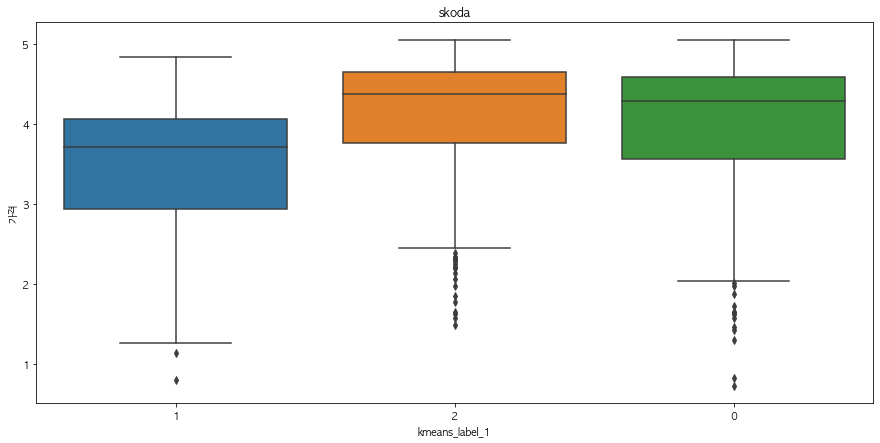

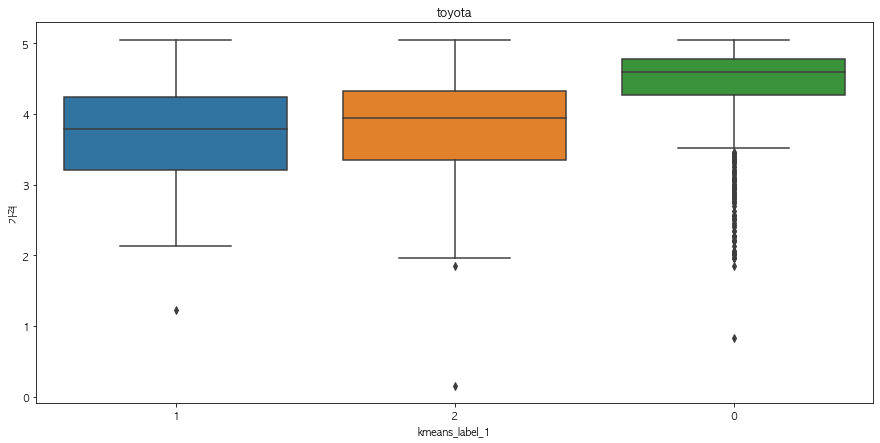

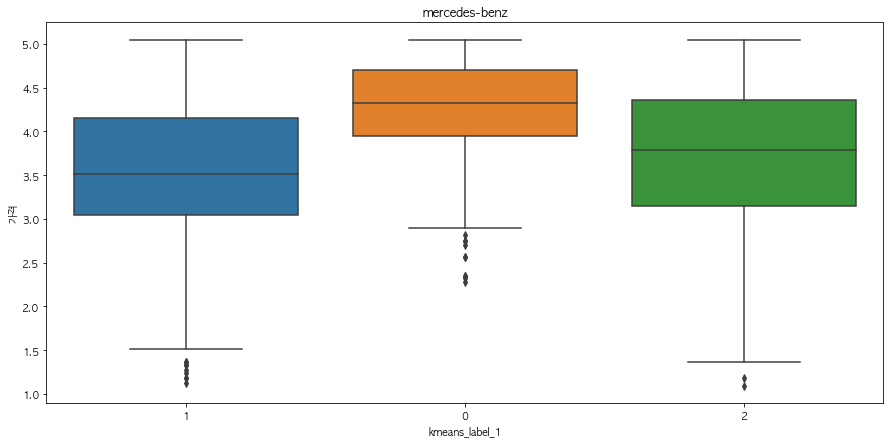

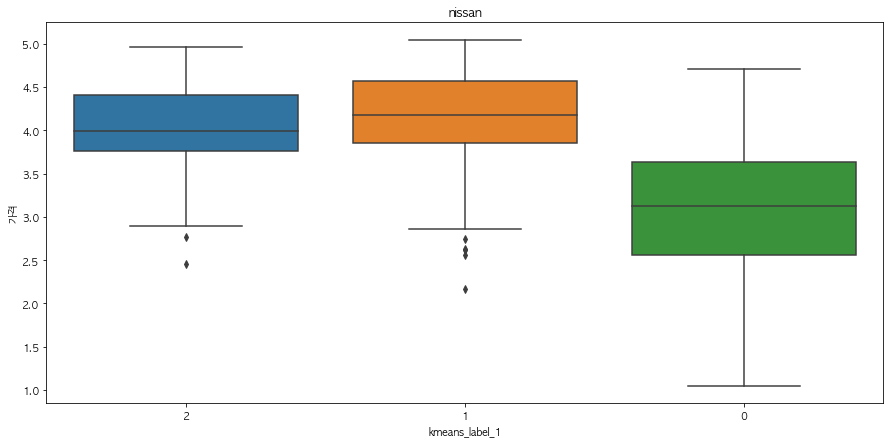

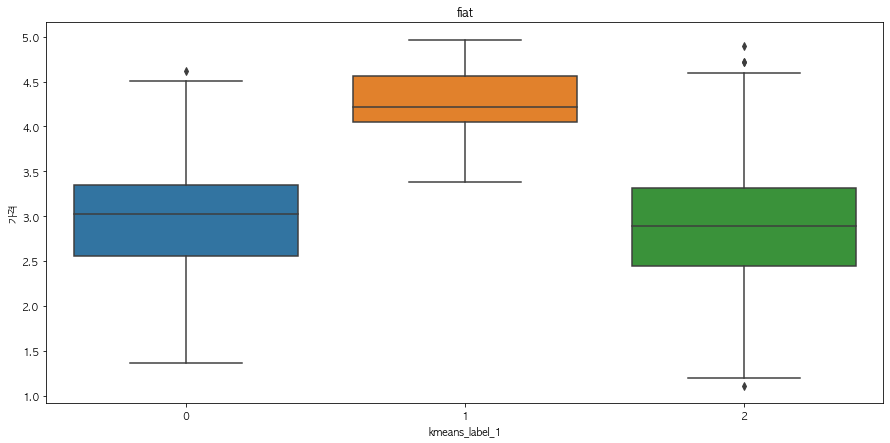

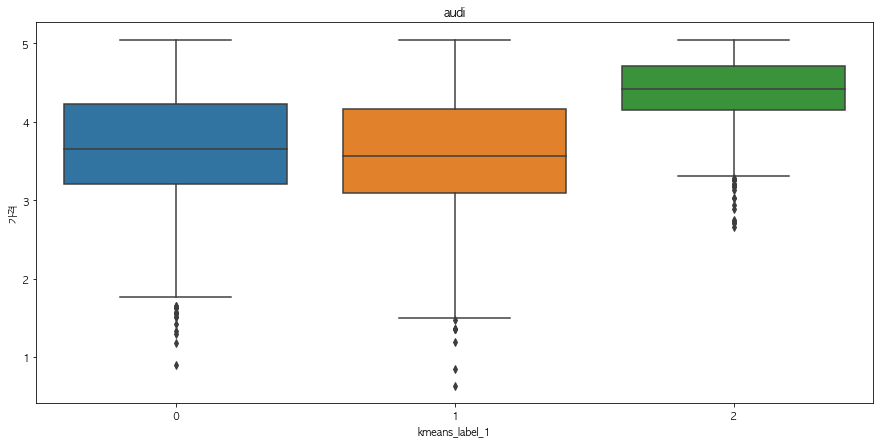

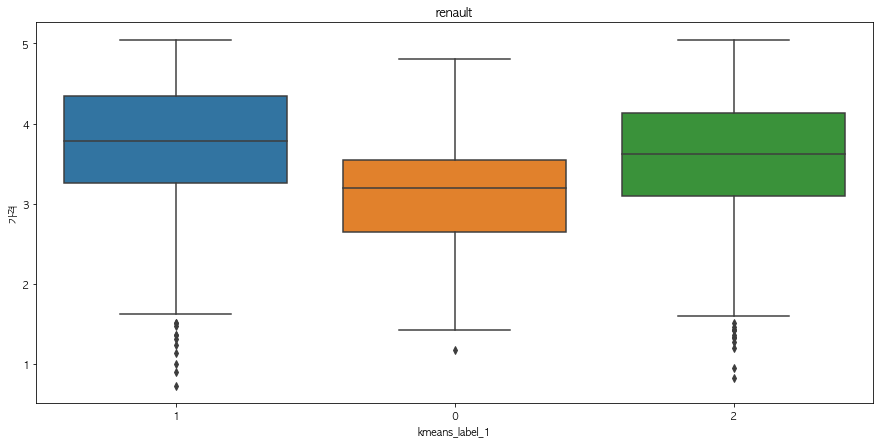

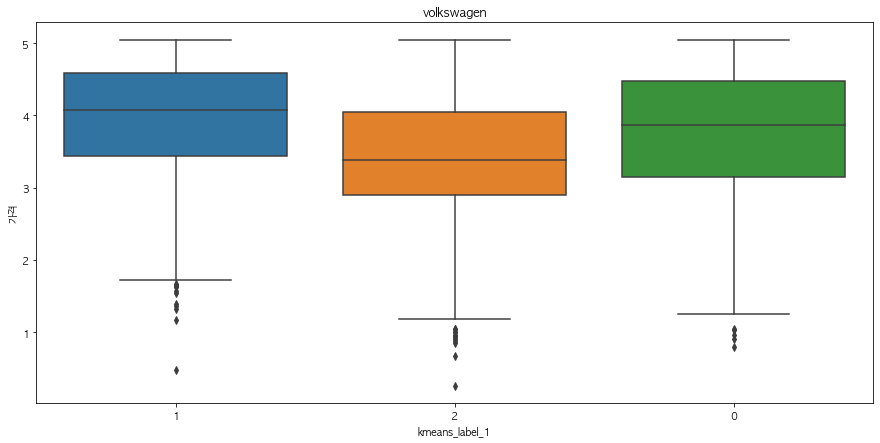

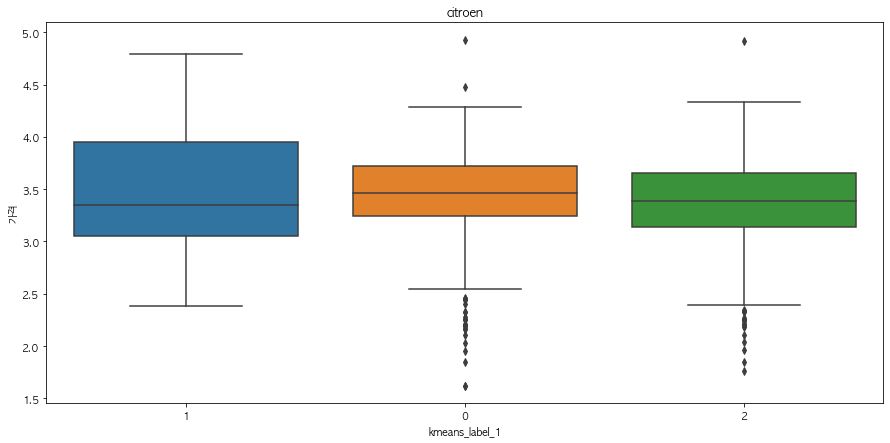

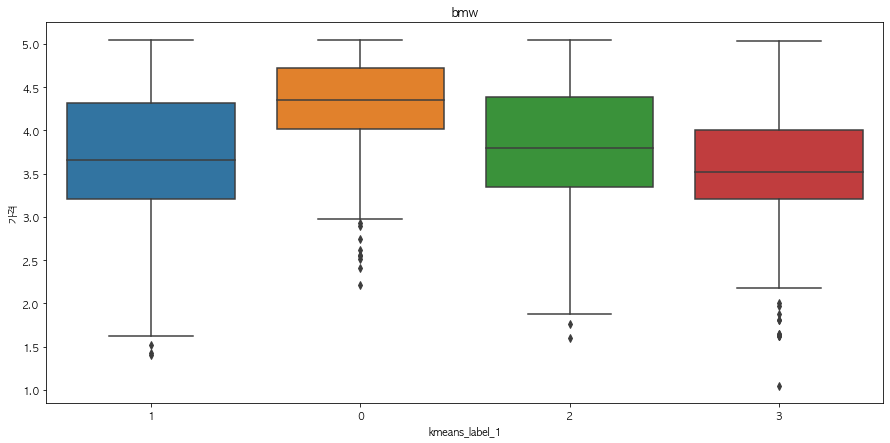

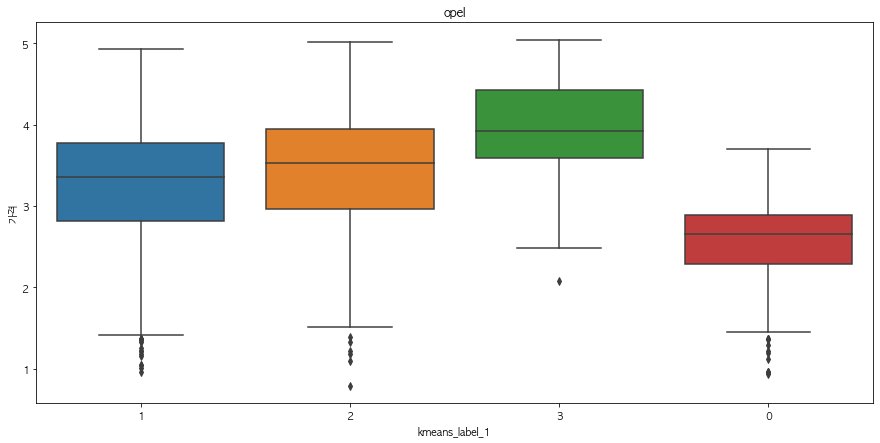

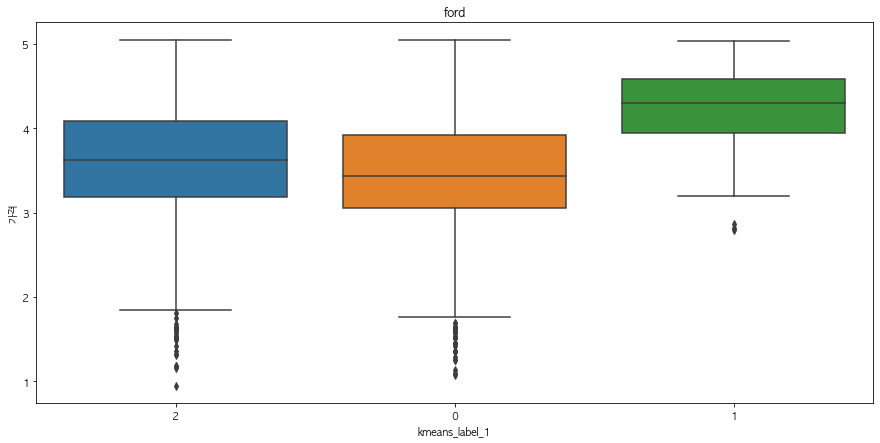

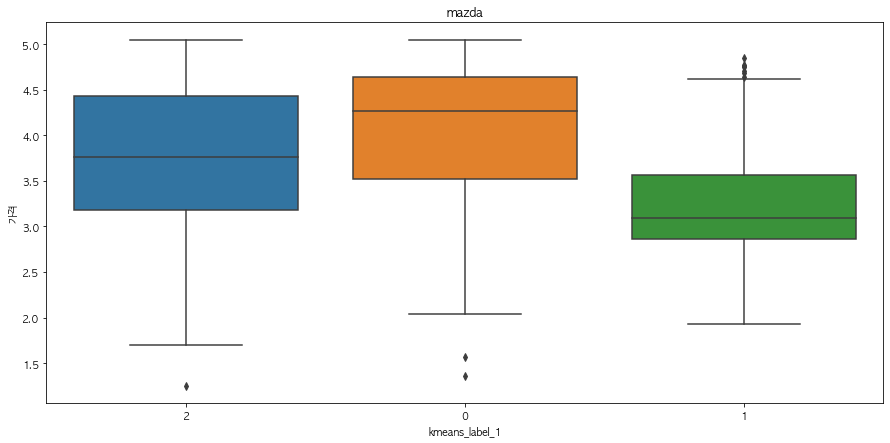

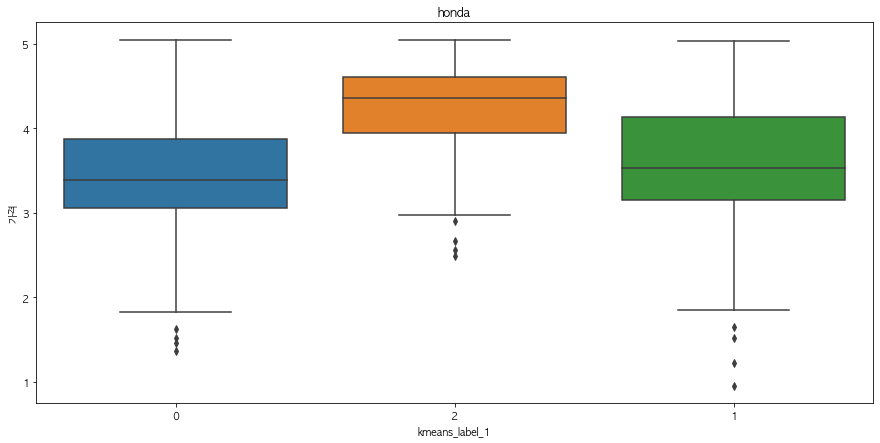

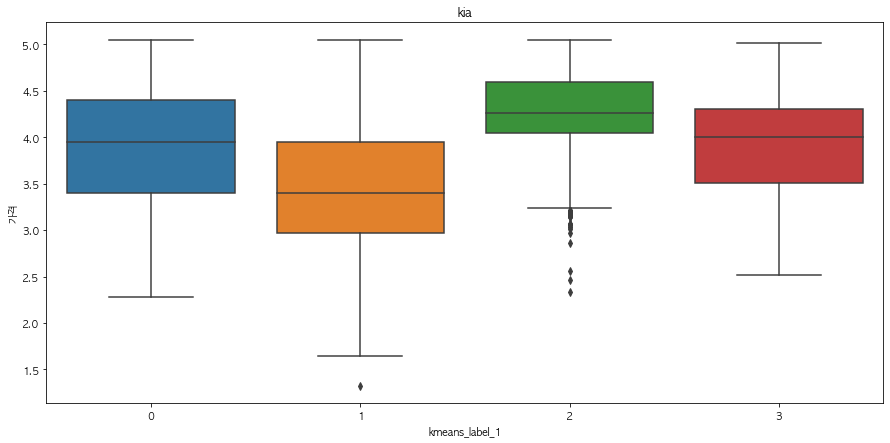

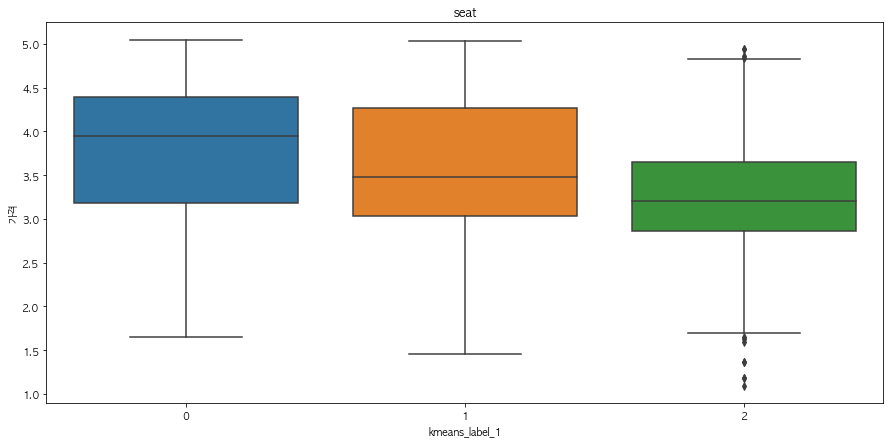

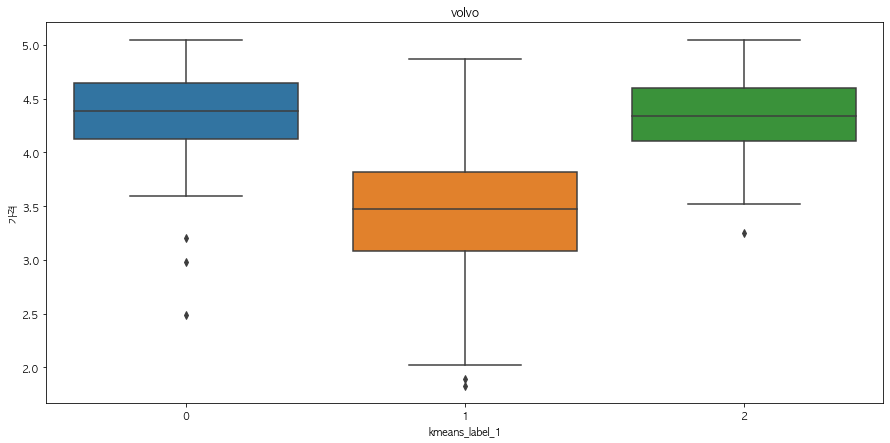

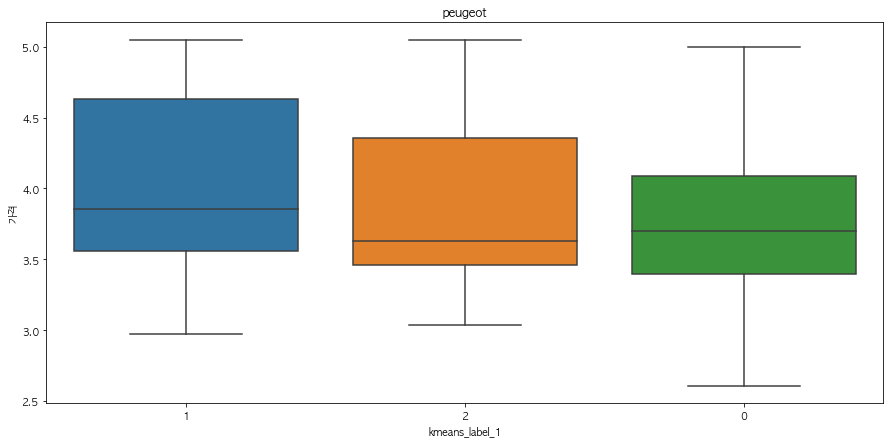

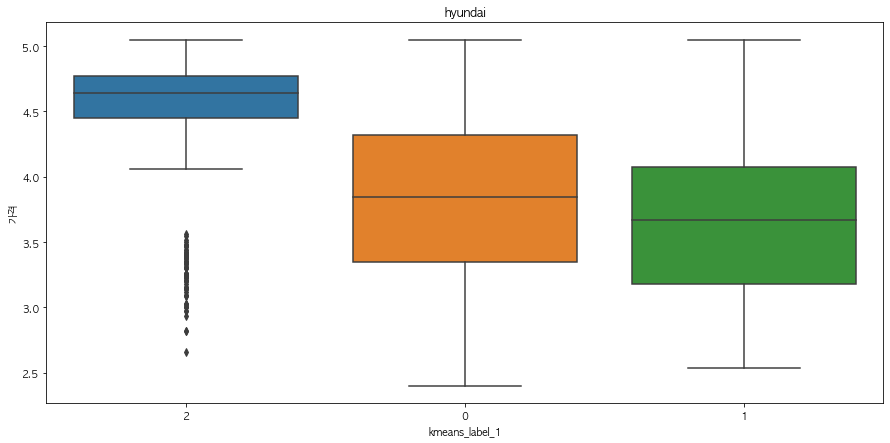

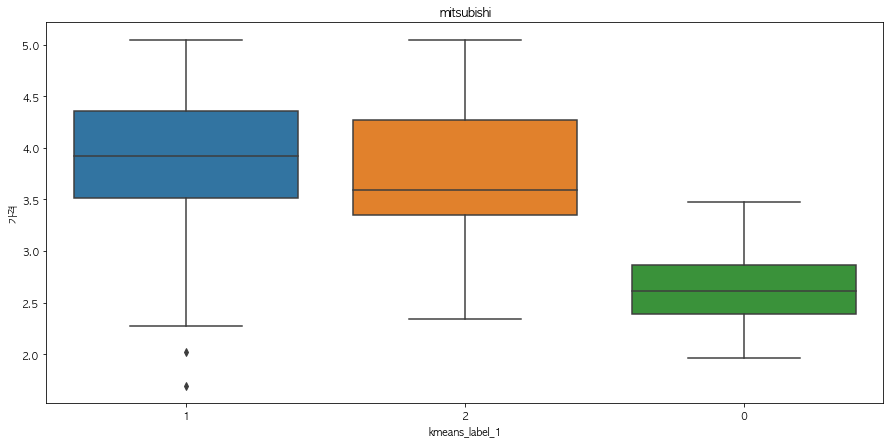

In [46]:
kmeans_i = 1

for seg in segment_list:
    d = train_df6[train_df6.segment==seg]

    plt.figure(figsize=(15,7))
    sns.boxplot(x=d[f'kmeans_label_{kmeans_i}'],y=d[target_feature])
    plt.title(seg)
    plt.show()

In [47]:
type_controller = TypeController(
    target_feature='가격',
    cat_features=fe.cat_features+fe.new_cat_features+kmeans_label_features,
    unuse_features=CFG.UNUSE_FEATURES,
    segment_feature='segment',
)
type_controller.fit(
    data=train_df6,
    global_assignment=True,
    verbose=True,
)

train_df6 = type_controller.transform(train_df6)
test_df6  = type_controller.transform(test_df6)

> gloval variable assignment
[1] complete: target_feature
[2] complete: unuse_features
[3] complete: dummy_features
[4] complete: cat_features
[5] complete: num_features
[6] complete: segment_feature


In [48]:
print(train_df6.shape)
train_df6.head()

(57920, 45)


,ID,생산년도,모델출시년도,차량모델명,판매도시,판매구역,주행거리,배기량,가격,출시년도생산여부,출시이후생산년수,출시이전생산여부,브랜드국적,브랜드대륙명,가스,연료타입,판매도시구역동일여부,배기량_grp,production_year_grp,브랜드_Avg,브랜드_Q25,브랜드_Q50,브랜드_Q75,차량모델명_Avg,차량모델명_Q25,차량모델명_Q50,차량모델명_Q75,판매구역_Avg,판매구역_Q25,판매구역_Q50,판매구역_Q75,브랜드_차량모델명_Avg,브랜드_차량모델명_Q25,브랜드_차량모델명_Q50,브랜드_차량모델명_Q75,브랜드_판매구역_Avg,브랜드_판매구역_Q25,브랜드_판매구역_Q50,브랜드_판매구역_Q75,segment,kmeans_label_1,kmeans_label_2,kmeans_label_3,kmeans_label_4,kmeans_label_5
0,TRAIN_00000,0.834442,0.724582,fabia,KAT,SLA,-0.836065,-1.575697,3.946231,0,0.095535,0,체코,유럽,0,가솔린,0,900.0,0,-8.881784e-16,-4.440892e-16,-8.881784e-16,1.776357e-15,-1.289723,-1.257159,-1.352954,-1.324219,0.260894,0.076129,0.219604,0.502768,-1.289723,-1.257159,-1.352954,-1.324219,0.294547,0.453850,-0.080343,0.409862,skoda,1,1,1,2,0
1,TRAIN_00001,-0.613603,-0.752969,auris,RKO,SWI,0.024455,-0.023767,3.724970,0,0.166189,0,일본,아시아,0,가솔린,0,1500.0,1,0.000000e+00,8.881784e-16,1.776357e-15,8.881784e-16,0.345921,0.281534,0.295228,0.040522,-2.006230,-1.017156,-2.241310,-2.735300,0.345921,0.281534,0.295228,0.040522,-0.704950,-0.303903,-1.040675,-1.631444,toyota,1,2,1,0,0
2,TRAIN_00002,-1.143023,-0.562400,clk-klasa,GNI,WIE,0.499560,-0.673600,2.879760,1,-1.347041,1,독일,유럽,0,가솔린,0,1700.0,1,0.000000e+00,4.440892e-16,1.332268e-15,-8.881784e-16,-1.065284,-0.238086,-0.677804,-2.852173,-0.696033,-1.079302,-0.252732,-0.006405,-1.065284,-0.238086,-0.677804,-2.852173,-0.417619,-0.508368,-0.113595,-0.136579,mercedes-benz,1,0,1,2,0
3,TRAIN_00003,-1.476101,-2.086687,x-trail,EHX,WIE,1.591089,2.038881,2.901422,0,0.739109,0,일본,아시아,0,경유,0,2100.0,1,0.000000e+00,0.000000e+00,0.000000e+00,8.881784e-16,0.977428,1.440628,1.526758,1.058689,-0.782043,-1.200983,-0.304308,-0.039559,0.977428,1.440628,1.526758,1.058689,-0.656350,-0.740974,0.127434,-0.383612,nissan,2,0,0,0,0
4,TRAIN_00004,-1.195204,-0.462942,bravo,OSW,MAL,1.710821,2.776681,2.865054,1,-1.240315,1,이탈리아,유럽,0,경유,0,1900.0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.689201,-0.382146,-0.612669,-1.108377,0.184164,0.174178,0.191462,0.003637,-0.689201,-0.382146,-0.612669,-1.108377,0.321677,0.063393,-0.024993,0.881700,fiat,0,0,2,1,1


<br></br>

# Add the Interaction Term

In [49]:
import warnings
from tqdm import trange

def get_abs_corr(x,y):
    return np.abs(np.corrcoef(x,y))[0,1]

class InteractionTerm:
    def __init__(self):
        pass
    
    def fit(self,data,num_features,corr_cutoff=0.7):
        warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
        
        d = data.copy()
        self.interaction_list = []
        for i in range(len(num_features)):
            for j in range(len(num_features)):
                if i>j:
                    col_i = num_features[i]
                    col_j = num_features[j]
                    
                    # 상관계수가 cutoff보다 큰 경우에는 interaction을 생성하지 않음
                    if (get_abs_corr(d[col_i]*d[col_j],d[col_i])>=corr_cutoff) | (get_abs_corr(d[col_i]*d[col_j],d[col_j])>=corr_cutoff):
                        pass
                    else:
                        self.interaction_list.append(f'{col_i}*{col_j}')
    
    def transform(self,data):
        d = data.copy()
        for interaction in self.interaction_list:
            col_i,col_j = interaction.split('*')
            d[interaction] = d[col_i]*d[col_j]
        return d
    
    def fit_transform(self,data,num_features,corr_cutoff=0.7):
        self.fit(data,num_features,corr_cutoff)
        return self.transform(data)

In [50]:
train_df7 = train_df6.copy()
test_df7  = test_df6.copy()

if CFG.INTERACTION:
    interaction_features = [f for f in num_features if (f.find('_Avg')<0) & (f.find('_Q')<0)]
    
    interaction_maker = InteractionTerm()
    interaction_maker.fit(
        data=train_df7,
        num_features=num_features,
        corr_cutoff=0.7,
    )
    train_df7 = interaction_maker.transform(train_df7)
    test_df7  = interaction_maker.transform(test_df7)

    type_controller = TypeController(
        target_feature='가격',
        cat_features=kmeans_label_features,
        unuse_features=CFG.UNUSE_FEATURES,
        segment_feature='segment',
    )
    type_controller.fit(
        data=train_df7,
        global_assignment=True,
        verbose=True,
    )

    train_df7 = type_controller.transform(train_df7)
    test_df7  = type_controller.transform(test_df7)

In [51]:
print(train_df7.shape)
train_df7.head()

(57920, 45)


,ID,생산년도,모델출시년도,차량모델명,판매도시,판매구역,주행거리,배기량,가격,출시년도생산여부,출시이후생산년수,출시이전생산여부,브랜드국적,브랜드대륙명,가스,연료타입,판매도시구역동일여부,배기량_grp,production_year_grp,브랜드_Avg,브랜드_Q25,브랜드_Q50,브랜드_Q75,차량모델명_Avg,차량모델명_Q25,차량모델명_Q50,차량모델명_Q75,판매구역_Avg,판매구역_Q25,판매구역_Q50,판매구역_Q75,브랜드_차량모델명_Avg,브랜드_차량모델명_Q25,브랜드_차량모델명_Q50,브랜드_차량모델명_Q75,브랜드_판매구역_Avg,브랜드_판매구역_Q25,브랜드_판매구역_Q50,브랜드_판매구역_Q75,segment,kmeans_label_1,kmeans_label_2,kmeans_label_3,kmeans_label_4,kmeans_label_5
0,TRAIN_00000,0.834442,0.724582,fabia,KAT,SLA,-0.836065,-1.575697,3.946231,0,0.095535,0,체코,유럽,0,가솔린,0,900.0,0,-8.881784e-16,-4.440892e-16,-8.881784e-16,1.776357e-15,-1.289723,-1.257159,-1.352954,-1.324219,0.260894,0.076129,0.219604,0.502768,-1.289723,-1.257159,-1.352954,-1.324219,0.294547,0.453850,-0.080343,0.409862,skoda,1,1,1,2,0
1,TRAIN_00001,-0.613603,-0.752969,auris,RKO,SWI,0.024455,-0.023767,3.724970,0,0.166189,0,일본,아시아,0,가솔린,0,1500.0,1,0.000000e+00,8.881784e-16,1.776357e-15,8.881784e-16,0.345921,0.281534,0.295228,0.040522,-2.006230,-1.017156,-2.241310,-2.735300,0.345921,0.281534,0.295228,0.040522,-0.704950,-0.303903,-1.040675,-1.631444,toyota,1,2,1,0,0
2,TRAIN_00002,-1.143023,-0.562400,clk-klasa,GNI,WIE,0.499560,-0.673600,2.879760,1,-1.347041,1,독일,유럽,0,가솔린,0,1700.0,1,0.000000e+00,4.440892e-16,1.332268e-15,-8.881784e-16,-1.065284,-0.238086,-0.677804,-2.852173,-0.696033,-1.079302,-0.252732,-0.006405,-1.065284,-0.238086,-0.677804,-2.852173,-0.417619,-0.508368,-0.113595,-0.136579,mercedes-benz,1,0,1,2,0
3,TRAIN_00003,-1.476101,-2.086687,x-trail,EHX,WIE,1.591089,2.038881,2.901422,0,0.739109,0,일본,아시아,0,경유,0,2100.0,1,0.000000e+00,0.000000e+00,0.000000e+00,8.881784e-16,0.977428,1.440628,1.526758,1.058689,-0.782043,-1.200983,-0.304308,-0.039559,0.977428,1.440628,1.526758,1.058689,-0.656350,-0.740974,0.127434,-0.383612,nissan,2,0,0,0,0
4,TRAIN_00004,-1.195204,-0.462942,bravo,OSW,MAL,1.710821,2.776681,2.865054,1,-1.240315,1,이탈리아,유럽,0,경유,0,1900.0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.689201,-0.382146,-0.612669,-1.108377,0.184164,0.174178,0.191462,0.003637,-0.689201,-0.382146,-0.612669,-1.108377,0.321677,0.063393,-0.024993,0.881700,fiat,0,0,2,1,1


<br></br>

# Feature Selection

In [52]:
# k=0
# for i in range(len(num_features)):
#     for j in range(len(num_features)):
#         if i>j:
#             col_i = num_features[i]
#             col_j = num_features[j]
#             corr = np.corrcoef(train_df5[col_i],train_df5[col_j])[0,1]
#             if corr>=0.7:
#                 k+=1
#                 print(k,col_i,col_j,corr)

In [53]:
# import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy

In [54]:
class FilterMethodFeatureSelection:
    def __init__(self):
        pass
        
    def _feature_selection_categorical(self,dataset,cat_features,target_feature,alpha,verbose):
        data = dataset.copy()
        delete_features = []
        
        # (1) ANOVA를 해서 p-value가 0.05보다 높은 것들 확인
        if verbose:
            pbar = tqdm(cat_features,desc='[1/3] Categorical Feature Selection')
        else:
            pbar = cat_features
        pvalue_list = []
        for col in pbar:
            if data[col].nunique()==1:
                delete_features.append(col)
            else:
                d = data[[col,target_feature]].rename(columns={col:'feature',target_feature:'target'})
                model = ols(f'target ~ C(feature)',data=d).fit()
                pvalue = anova_lm(model).values[0][-1]
                pvalue_list.append([col,pvalue])
        pvalue_df = pd.DataFrame(pvalue_list,columns=['feature','pvalue'])\
            .sort_values('pvalue',ascending=False)
        # pvalue_df[pvalue_df.pvalue>=alpha].round(4)
        
        # (3) log변환을 했음에도 pvalue>alpha인 변수들은 삭제
        #     log변환을 해서 pvalue<=alpha인 변수들은 log변환을 해줌
        delete_features += pvalue_df[pvalue_df.pvalue>alpha].feature.tolist()
        if verbose:
            print('> categorical: delete_features')
            print('  - length : {}'.format(len(delete_features)))
            print('  - feature_name : {}'.format(delete_features))
        
        return delete_features
    
    def _feature_selection_numerical(self,dataset,num_features,target_feature,alpha,verbose):
        data = dataset.copy()
        delete_features = []
        
        # (1) corr test를 해서 p-value가 0.05보다 높은 것들 확인
        if verbose:
            pbar = tqdm(num_features,desc='[2/3] Check all numerical features')
        else:
            pbar = num_features
        pvalue_list = []
        for col in pbar:
            if data[col].nunique()==1:
                delete_features.append(col)
            else:
                corr,pvalue = scipy.stats.pearsonr(data[target_feature],data[col])
                pvalue_list.append([col,pvalue])
        pvalue_df = pd.DataFrame(pvalue_list,columns=['feature','pvalue'])\
            .sort_values('pvalue',ascending=False)
        # pvalue_df.round(4).head()
        
        # (2) (1)에서 유의하지않은 feature들은 log적용 후에도 유의하지 않으면 제외
        insignificant_features = pvalue_df[pvalue_df.pvalue>alpha].feature.tolist()
        if verbose:
            pbar = tqdm(insignificant_features,desc='[3/3] Log transformation to insignificant numerical features')
        else:
            pbar = insignificant_features
        pvalue_list2 = []
        for col in pbar:
            if data[col].nunique()==1:
                delete_features.append(col)
            else:
                corr,pvalue = scipy.stats.pearsonr(data[target_feature],log_offset(data[col],verbose=False))
                pvalue_list2.append([col,pvalue])
        pvalue_df2 = pd.DataFrame(pvalue_list2,columns=['feature','pvalue'])\
            .sort_values('pvalue',ascending=False)
        # pvalue_df2.round(4).head()
        
        delete_features += pvalue_df2[pvalue_df2.pvalue> alpha].feature.tolist()
        log_features     = pvalue_df2[pvalue_df2.pvalue<=alpha].feature.tolist()
        if verbose:
            print('> numerical: delete_features')
            print('  - length : {}'.format(len(delete_features)))
            print('  - feature_name : {}'.format(delete_features))
            print('> numerical: log_features')
            print('  - length : {}'.format(len(log_features)))
            print('  - feature_name : {}'.format(log_features))

        return delete_features, log_features
        
    def fit(self,dataset,num_features,cat_features,target_feature,alpha=0.01,verbose=True):
        self.cat_delete_features = self._feature_selection_categorical(
            dataset,cat_features,target_feature,alpha,verbose)
        self.num_delete_features, self.num_log_features = self._feature_selection_numerical(
            dataset,num_features,target_feature,alpha,verbose)
        
        self.cat_delete_features = list(set(self.cat_delete_features)-set([target_feature]))
        self.num_delete_features = list(set(self.num_delete_features)-set([target_feature]))
        self.num_log_features    = list(set(self.num_log_features)   -set([target_feature]))
        
    def transform(self,dataset):
        data = dataset.copy()
        data.drop(columns=self.cat_delete_features+self.num_delete_features,inplace=True)
        for col in self.num_log_features:
            data[col] = log_offset(data[col],verbose=False)
        return data

In [55]:
# feature selection
feature_selector = FilterMethodFeatureSelection()
feature_selector.fit(
    dataset=train_df7,
    num_features=num_features,
    cat_features=[col for col in cat_features if train_df7[col].nunique()<=100],
    target_feature=target_feature,
    alpha=CFG.FS_ALPHA,
    verbose=True,
)
train_df8 = feature_selector.transform(train_df7)
test_df8  = feature_selector.transform(test_df7)

# type control
type_controller = TypeController(
    target_feature='가격',
    cat_features=fe.cat_features+fe.new_cat_features+kmeans_label_features,
    unuse_features=CFG.UNUSE_FEATURES,
    segment_feature='segment',
)
type_controller.fit(
    data=train_df8,
    global_assignment=True,
    verbose=True,
)

train_df8 = type_controller.transform(train_df8)
test_df8  = type_controller.transform(test_df8)

[1/3] Categorical Feature Selection: 100%|██████████| 11/11 [00:03<00:00,  3.29it/s]


> categorical: delete_features
  - length : 0
  - feature_name : []


[2/3] Check all numerical features: 100%|██████████| 25/25 [00:00<00:00, 86.20it/s]
[3/3] Log transformation to insignificant numerical features: 100%|██████████| 1/1 [00:00<00:00, 38.09it/s]


> numerical: delete_features
  - length : 1
  - feature_name : ['브랜드_Q50']
> numerical: log_features
  - length : 0
  - feature_name : []
> gloval variable assignment
[1] complete: target_feature
[2] complete: unuse_features
[3] complete: dummy_features
[4] complete: cat_features
[5] complete: num_features
[6] complete: segment_feature


<br></br>

# Outlier Detection

In [56]:
# plt.figure(figsize=(15,8))
# sns.boxplot(x=train_df7['segment'],y=train_df7['가격'],order=sorted(train_df7.segment.unique()))
# plt.xticks(rotation=90)
# plt.show()

In [57]:
# Q1,Q3를 기준으로 1.5 IQR보다 멀리있는 값들을 Outlier로 판단하여 제거함
class OutlierDetect:
    def __init__(self,target_feature,group=None):
        self.target_feature = target_feature
        self.group = group
    
    def _get_outlier(self,data,target_feature,whis):
        target = data[target_feature]
        q1,q2,q3 = target.quantile([0.25,0.50,0.75]).values
        outlier_lower = q1 - whis*(q3-q1)
        outlier_upper = q3 + whis*(q3-q1)
        outlier_boundary = [
            outlier_lower,
            q1,
            q2,
            q3,
            outlier_upper,
            np.where((target<outlier_lower)|(target>outlier_upper),1,0).sum(),
            np.where((target<outlier_lower)|(target>outlier_upper),1,0).sum() / len(target),
            len(target),
        ]
        return outlier_boundary
    
    def fit(self,data,whis=1.5):
        assert self.target_feature in data.columns, \
            "No {} column in the data".format(self.target_feature)
        self.data = data
        
        if self.group is None:
            outlier_boundary = self._get_outlier(self.data,self.target_feature,whis)
            self.outlier_boundary = pd.DataFrame(
                [outlier_boundary],
                columns=['outlier_lower','Q1','Q2','Q3','outlier_upper','n_outlier','p_outlier','n_total'],
            )
        else:
            self.group_list = self.data[self.group].unique()
            outlier_boundary_list = []
            for group in self.group_list:
                d = self.data[self.data[self.group]==group]
                outlier_boundary = [group]+self._get_outlier(d,self.target_feature,whis)
                outlier_boundary_list.append(outlier_boundary)
            self.outlier_boundary = pd.DataFrame(
                outlier_boundary_list,
                columns=['group','outlier_lower','Q1','Q2','Q3','outlier_upper',
                         'n_outlier','p_outlier','n_total'],
            )
    
    def transform(self,data,max_example=4,verbose=True):
        example = []
        if self.group is None:
            if len(self.outlier_boundary)!=1:
                raise ValueError('length of self.outlier_boundary_df must be 1')
            else:
                d = data.copy()
                outlier_lower = self.outlier_boundary.outlier_lower.values[0]
                outlier_upper = self.outlier_boundary.outlier_upper.values[0]
                outlier_in = (d[self.target_feature]>=outlier_lower)&(d[self.target_feature]<=outlier_upper)
                new_data = d[outlier_in]
                ex = d[self.target_feature][~outlier_in]
                if len(ex)>0:
                    ex = sorted([round(e,3) for e in ex])
                    if len(ex)>max_example:
                        ex = ex[:2]+['...']+ex[-2:]
                else:
                    ex = ''
                example.append(ex)
        else:
            check_1 = list(set(self.group_list)-set(data[self.group].unique()))
            check_2 = list(set(data[self.group].unique())-set(self.group_list))
            if (len(check_1)==0) & (len(check_2)==0):
                pass
            elif (len(check_1)>0) & (len(check_2)==0):
                pass
            else:
                raise ValueError('Unknown group values')
            
            new_data = []
            for group in self.group_list:
                d = data[data[self.group]==group]
                outlier_d = self.outlier_boundary[self.outlier_boundary['group']==group]
                if len(outlier_d)!=1:
                    raise ValueError('length of self.outlier_boundary_df must be 1')
                else:
                    outlier_lower = outlier_d.outlier_lower.values[0]
                    outlier_upper = outlier_d.outlier_upper.values[0]
                    outlier_in = (d[self.target_feature]>=outlier_lower)&(d[self.target_feature]<=outlier_upper)
                    new_d = d[outlier_in]
                    new_data.append(new_d)
                    ex = d[self.target_feature][~outlier_in]
                    if len(ex)>0:
                        ex = sorted([round(e,3) for e in ex])
                        if len(ex)>max_example:
                            ex = ex[:2]+['...']+ex[-2:]
                    else:
                        ex = ''
                    example.append(ex)
            new_data = pd.concat(new_data,axis=0)
        
        self.outlier_boundary['example'] = example
        self.example = example
        
        if verbose:
            print("> {:,}'s outliers deleted ({:,}->{:,})".format(len(data)-len(new_data),len(data),len(new_data)))
            
        return new_data
    
    def fit_transform(self,data,whis=1.5,max_example=4,verbose=True):
        self.fit(data,whis)
        return self.transform(data=data,verbose=verbose)

In [58]:
train_df9 = train_df8.copy()
test_df9  = test_df8 .copy()

check_num_features = [col for col in num_features if col.find('_')<0] + ['가격']

outlier_boundary = []
total_n_outlier = 0
i=0
for col in check_num_features:
    i+=1
    print('[{}/{}] {}'.format(i,len(check_num_features),col))
    outlier_detector = OutlierDetect(
        target_feature='가격',
        group='segment',
    )
    train_df9 = outlier_detector.fit_transform(
        data=train_df9,
        whis=2,
        max_example=4,
    )
    train_df9.reset_index(drop=True,inplace=True)
    
    _outlier_boundary = outlier_detector.outlier_boundary.copy()
    _outlier_boundary.insert(0,'target_feature',col)
    _outlier_boundary = _outlier_boundary.reset_index().rename(columns={'index':'no'})
    _outlier_boundary.no+=1
    outlier_boundary.append(_outlier_boundary)
    
    total_n_outlier += _outlier_boundary.n_outlier.sum()
    
print('\n> Total n_outliers: {}({:.2f}%)'.format(total_n_outlier,100*total_n_outlier/len(train_df8)))

[1/6] 생산년도
> 59's outliers deleted (57,920->57,861)
[2/6] 모델출시년도
> 4's outliers deleted (57,861->57,857)
[3/6] 주행거리
> 0's outliers deleted (57,857->57,857)
[4/6] 배기량
> 0's outliers deleted (57,857->57,857)
[5/6] 출시이후생산년수
> 0's outliers deleted (57,857->57,857)
[6/6] 가격
> 0's outliers deleted (57,857->57,857)

> Total n_outliers: 63(0.11%)


In [59]:
outlier_boundary_df = pd.concat(outlier_boundary,axis=0)
outlier_boundary_df[outlier_boundary_df.n_outlier!=0]\
    .round(3).sort_values('p_outlier',ascending=False).head()

,no,target_feature,group,outlier_lower,Q1,Q2,Q3,outlier_upper,n_outlier,p_outlier,n_total,example
16,17,생산년도,volvo,2.482,3.843,4.209,4.524,5.885,16,0.012,1352,"[1.831, 1.892, ..., 2.448, 2.46]"
3,4,생산년도,nissan,1.864,3.558,3.923,4.405,6.100,19,0.009,2129,"[1.051, 1.256, ..., 1.852, 1.852]"
8,9,생산년도,citroen,1.697,3.090,3.394,3.786,5.178,2,0.002,1129,"[1.623, 1.623]"
3,4,모델출시년도,nissan,1.912,3.584,3.926,4.420,6.091,4,0.002,2110,"[1.872, 1.872, 1.872, 1.911]"
0,1,생산년도,skoda,1.162,3.394,4.058,4.509,6.740,4,0.001,3130,"[0.728, 0.793, 0.82, 1.138]"


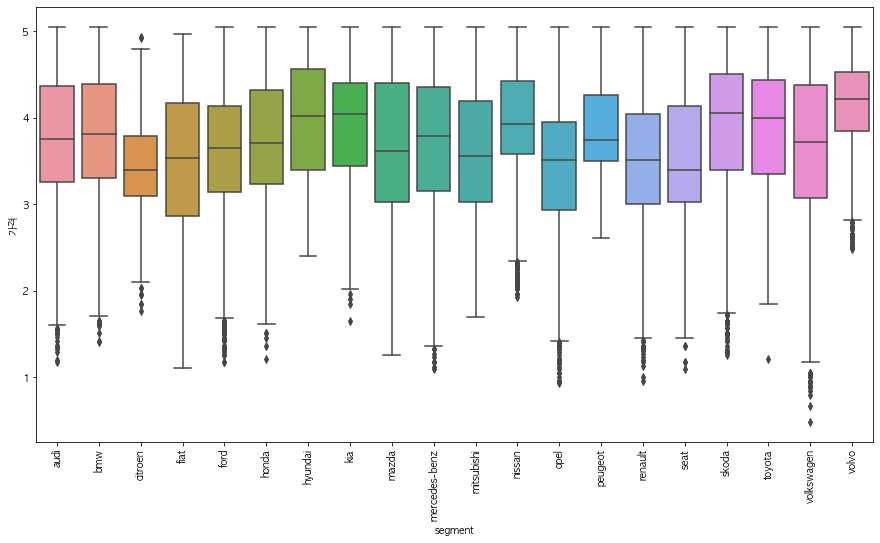

In [60]:
plt.figure(figsize=(15,8))
sns.boxplot(x=train_df9['segment'],y=train_df9['가격'],order=sorted(train_df9.segment.unique()))
plt.xticks(rotation=90)
plt.show()

In [61]:
train_df8.shape[0], train_df9.shape[0]

(57920, 57857)

In [62]:
print(train_df9.shape)
train_df9.head()

(57857, 44)


,ID,생산년도,모델출시년도,차량모델명,판매도시,판매구역,주행거리,배기량,가격,출시년도생산여부,출시이후생산년수,출시이전생산여부,브랜드국적,브랜드대륙명,가스,연료타입,판매도시구역동일여부,배기량_grp,production_year_grp,브랜드_Avg,브랜드_Q25,브랜드_Q75,차량모델명_Avg,차량모델명_Q25,차량모델명_Q50,차량모델명_Q75,판매구역_Avg,판매구역_Q25,판매구역_Q50,판매구역_Q75,브랜드_차량모델명_Avg,브랜드_차량모델명_Q25,브랜드_차량모델명_Q50,브랜드_차량모델명_Q75,브랜드_판매구역_Avg,브랜드_판매구역_Q25,브랜드_판매구역_Q50,브랜드_판매구역_Q75,segment,kmeans_label_1,kmeans_label_2,kmeans_label_3,kmeans_label_4,kmeans_label_5
0,TRAIN_00000,0.834442,0.724582,fabia,KAT,SLA,-0.836065,-1.575697,3.946231,0,0.095535,0,체코,유럽,0,가솔린,0,900.0,0,-8.881784e-16,-4.440892e-16,1.776357e-15,-1.289723,-1.257159,-1.352954,-1.324219,0.260894,0.076129,0.219604,0.502768,-1.289723,-1.257159,-1.352954,-1.324219,0.294547,0.453850,-0.080343,0.409862,skoda,1,1,1,2,0
1,TRAIN_00008,0.834442,0.724582,fabia,OPO,OPO,-0.672049,-1.572931,4.131480,0,0.095535,0,체코,유럽,0,가솔린,1,1000.0,0,-8.881784e-16,-4.440892e-16,1.776357e-15,-1.289723,-1.257159,-1.352954,-1.324219,0.185650,0.123580,0.332028,0.216163,-1.289723,-1.257159,-1.352954,-1.324219,1.998544,0.905301,2.704455,1.840531,skoda,1,1,1,2,0
2,TRAIN_00034,0.425581,0.911690,superb,MYS,SLA,0.147670,1.104964,4.738564,0,-1.274048,0,체코,유럽,0,경유,0,1900.0,0,-8.881784e-16,-4.440892e-16,1.776357e-15,1.436570,1.505489,1.260896,1.349592,0.260894,0.076129,0.219604,0.502768,1.436570,1.505489,1.260896,1.349592,0.294547,0.453850,-0.080343,0.409862,skoda,2,2,2,1,2
3,TRAIN_00055,-1.005432,-0.398069,superb,PDO,MAL,0.420556,0.634672,3.728100,0,-1.274048,0,체코,유럽,0,가솔린,0,1700.0,0,-8.881784e-16,-4.440892e-16,1.776357e-15,1.436570,1.505489,1.260896,1.349592,0.034907,0.028427,0.048425,-0.098627,1.436570,1.505489,1.260896,1.349592,-0.091444,0.065020,-0.297069,-0.588978,skoda,0,0,0,0,1
4,TRAIN_00093,0.630012,0.537473,octavia,OLS,WAR,-1.387541,-1.575697,4.419684,0,0.095535,0,체코,유럽,0,가솔린,0,900.0,0,-8.881784e-16,-4.440892e-16,1.776357e-15,0.293752,0.241834,0.412268,0.354660,-1.423763,-0.462969,-1.858656,-2.308131,0.293752,0.241834,0.412268,0.354660,-1.000184,-1.386471,0.167662,-0.387170,skoda,0,0,0,0,1


<br></br>

# Memory Reduce

In [63]:
# https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(props,verbose=False):
    # Byte -> MB : 2^20
    asis_mem_usg = props.memory_usage().sum() / (2**20)
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    
    num_cols = props.columns[props.dtypes!=object]
    i=0
    total=len(num_cols)
    for col in num_cols:
        i+=1
        asis_dtype = props[col].dtype

        # make variables for Int, max and min
        IsInt = False
        mx = props[col].max()
        mn = props[col].min()

        # Integer does not support NA, therefore, NA needs to be filled
        if not np.isfinite(props[col]).all(): 
            NAlist.append(col)
            props[col].fillna(mn-1,inplace=True)  

        # test if column can be converted to an integer
        asint = props[col].fillna(0).astype(np.int64)
        result = (props[col] - asint)
        result = result.sum()
        if result > -0.01 and result < 0.01:
            IsInt = True

        # Make Integer/unsigned Integer datatypes
        if IsInt:
            if mn >= 0:
                if mx < 255:
                    props[col] = props[col].astype(np.uint8)
                elif mx < 65535:
                    props[col] = props[col].astype(np.uint16)
                elif mx < 4294967295:
                    props[col] = props[col].astype(np.uint32)
                else:
                    props[col] = props[col].astype(np.uint64)
            else:
                if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                    props[col] = props[col].astype(np.int8)
                elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                    props[col] = props[col].astype(np.int16)
                elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                    props[col] = props[col].astype(np.int32)
                elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                    props[col] = props[col].astype(np.int64)    

        # Make float datatypes 32 bit
        else:
            props[col] = props[col].astype(np.float32)

        tobe_dtype = props[col].dtype
        if verbose:
            text = '[{}/{}] {}: {} -> {}'.format(
                str(i).zfill(len(str(total))),total,col,asis_dtype,tobe_dtype)
            print(text)
    
    # na가 있으면 min-1로 넣었으므로, 이 값들을 다시 nan으로 변경
    for col in NAlist:
        props[col] = props[col].replace(props[col].min(),np.nan)
        
    tobe_mem_usg = props.memory_usage().sum() / (2**20)
    reduced_mem  = 100*tobe_mem_usg/asis_mem_usg
    
    if verbose:
        print('Memory reduced by {:.2f}% ({:.2f} MB → {:.2f} MB)'.format(reduced_mem,asis_mem_usg,tobe_mem_usg))
        
    return props, (asis_mem_usg, tobe_mem_usg, reduced_mem)

In [64]:
train_df10, _ = reduce_mem_usage(train_df9,verbose=False)
test_df10 , _ = reduce_mem_usage(test_df9 ,verbose=False)

In [65]:
train_df10.shape, test_df10.shape

((57857, 44), (14480, 43))

<br></br>

# Modeling

In [66]:
import os
def mkdir(paths):
    if type(paths)==str:
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            print('> Create Folder: {}'.format(path))
            os.mkdir(path)

In [67]:
def inverse_transform(x,func=['log','sqrt']):
    if func=='log':
        y = np.exp(x)
    elif func=='sqrt':
        y = np.square(x)
    else:
        raise ValueError('Unknown func')
    return y

In [68]:
mkdir('./model_checkpoints')
mkdir('./model_checkpoints/segment_catboost')
mkdir('./model_checkpoints/segment_weightedensemble')

In [69]:
assert train_df10.isnull().sum().sum()==0, \
    "Train: null detected"

assert test_df10.isnull().sum().sum()==0, \
    "Train: null detected"

<br>

## Check feature importance

In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
train_fn = train_df10.drop(columns=CFG.UNUSE_FEATURES)
test_fn  = test_df10 .drop(columns=CFG.UNUSE_FEATURES)

(1) 전체

In [ ]:
# %%time
# # 2분

# # (1) Fitting
# X = train_fn.drop(target_feature,axis=1)
# y = train_fn[target_feature]

# X_train, X_val, y_train, y_val = train_test_split(
#     X,y,test_size=0.2,random_state=CFG.SEED,stratify=X['segment'])

# train_dataset = Pool(X_train,y_train,cat_features=cat_features+['segment'])
# val_dataset   = Pool(X_val  ,y_val  ,cat_features=cat_features+['segment'])

# model = CatBoostRegressor(iterations=5000)
# model.fit(train_dataset,eval_set=val_dataset,metric_period=1000,early_stopping_rounds=100)

# # (2) Prediction
# y_pred = model.predict(val_dataset).flatten()
# y_true = y_val.values.flatten()

# y_pred = inverse_transform(y_pred,CFG.TARGET_TRANSFORMATION)
# y_true = inverse_transform(y_true,CFG.TARGET_TRANSFORMATION)

# mae = mean_absolute_error(y_true=y_true,y_pred=y_pred)
# print(mae)

# # (3) Plotting
# feature_importance = model.feature_importances_
# sorted_idx = np.argsort(feature_importance)
# plt.figure(figsize=(15,10))
# plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
# plt.title('Feature Importance')
# plt.show()

(2) segment별

In [ ]:
%%time
# 2분

segment_list = train_fn.segment.unique()

models = {}
i=0
for seg in segment_list:
    i+=1
    d = train_fn[train_fn.segment==seg].copy()
    d = d.drop('segment',axis=1)
        
    # (1) Fitting
    X = d.drop(target_feature,axis=1)
    y = d[target_feature]

    X_train, X_val, y_train, y_val = train_test_split(
        X,y,test_size=0.2,random_state=CFG.SEED)

    train_dataset = Pool(X_train,y_train,cat_features=cat_features)
    val_dataset   = Pool(X_val  ,y_val  ,cat_features=cat_features)

    model = CatBoostRegressor(iterations=5000)
    model.fit(train_dataset,eval_set=val_dataset,verbose=0)

    # (2) Prediction
    y_pred = model.predict(val_dataset).flatten()
    y_true = y_val.values.flatten()

    y_pred = inverse_transform(y_pred,CFG.TARGET_TRANSFORMATION)
    y_true = inverse_transform(y_true,CFG.TARGET_TRANSFORMATION)

    mae = mean_absolute_error(y_true=y_true,y_pred=y_pred)
    str_i = str(i).zfill(len(str(len(segment_list))))
    print('[{}/{}] {}: MAE({:.4f})'.format(str_i,len(segment_list),seg,mae))

    models[seg] = {}
    models[seg]['model'] = model
    models[seg]['feature'] = X_train.columns

In [ ]:
max_features = 50

segment_list = train_fn.segment.unique()
i=0
for seg in segment_list:
    i+=1
    model   = models[seg]['model']
    feature = models[seg]['feature']
    
    str_i = str(i).zfill(len(str(len(segment_list))))
    title = '[{}/{}] {}'.format(str_i,len(segment_list),seg)
    
    feature_importance = model.feature_importances_[:max_features]
    sorted_idx = np.argsort(feature_importance)[:max_features]
    plt.figure(figsize=(15,10))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(feature)[sorted_idx])
    plt.title(title)
    plt.show()

<br>

## CatBoost
- public score : 

In [ ]:
gc.collect()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool

In [ ]:
# train_fn = train_df10.copy()
# test_fn  = test_df10 .copy()

final_dict = deepcopy(final_segment_data_dict)

In [ ]:
%%time
# 1시간

segment_list = final_dict['segment_list']

models = {}
feature_info = {}
scores = []
pbar = tqdm(segment_list)

s_i = 0
for segment in pbar:
    s_i+=1
    gc.collect()
    
    tr_data = final_dict['train'][segment]
    
    type_controller = TypeController(
        target_feature='가격',
        cat_features=kmeans_label_features,
        unuse_features=CFG.UNUSE_FEATURES,
        segment_feature='segment',
    )
    type_controller.fit(
        data=tr_data,
        global_assignment=True,
        verbose=False,
    )
    tr_data = type_controller.transform(tr_data)
    
    # # segment에 해당하는 데이터추출
    # _X = X[X.segment==segment].drop('segment',axis=1)
    # _y = y[X.segment==segment]
    _X = tr_data.drop(columns=unuse_features+['segment',target_feature])
    _y = tr_data[target_feature]
    
    # kfold
    kf = KFold(n_splits=CFG.N_SPLITS,random_state=1000*s_i+CFG.SEED,shuffle=True)
    
    # unique인 컬럼 제외
    unique_info = _X.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X = _X.drop(unique_cols,axis=1)
        
    # categorical feature에서 unique인 컬럼을 제외
    fixed_cat_features = [col for col in cat_features if col in _X.columns]
    
    _models = []
    _scores = []
    k=0
    for tr_idx,val_idx in kf.split(_X,_y):
        k+=1
        
        # kfold dataset
        X_tr, X_va = _X.iloc[tr_idx], _X.iloc[val_idx]
        y_tr, y_va = _y.iloc[tr_idx], _y.iloc[val_idx]

        # progress
        progress = 'Segment: [{}], Size: [{:,}], KFold: [{}/{}]'\
            .format(segment,len(_X),k,CFG.N_SPLITS)
        pbar.set_description(progress)

        # dataset
        train_dataset = Pool(X_tr,y_tr,cat_features=fixed_cat_features)
        valid_dataset = Pool(X_va,y_va,cat_features=fixed_cat_features)

        # define the model
        model = CatBoostRegressor(
            loss_function='MAE',
            random_state=CFG.SEED,
            iterations=CFG.EPOCHS,
            learning_rate=CFG.LR,
            allow_writing_files=False,
        )

        # fit the model
        model.fit(
            train_dataset,
            eval_set=valid_dataset,
            early_stopping_rounds=CFG.ES,
            verbose=0,
            #metric_period=CFG.EPOCHS//5,
        )

        # save the model
        model.save_model(f'./model_checkpoints/segment_catboost/{segment}_k{k}.cbm')

        # prediction
        y_pred = model.predict(valid_dataset).flatten()
        y_true = y_va.values
        
        # inverse transform
        if CFG.TARGET_TRANSFORMATION=='log':
            y_pred = np.exp(y_pred)
            y_true = np.exp(y_true)
        elif CFG.TARGET_TRANSFORMATION=='sqrt':
            y_pred = np.square(y_pred)
            y_true = np.square(y_true)
            
        # calculate score
        score = mean_absolute_error(y_true=y_true,y_pred=y_pred)
        
        # append inner loop
        _models.append(model)
        _scores.append([segment,k,len(X_tr),len(X_va),score])

    # append outer loop
    models[segment] = _models
    scores.append(_scores)
    feature_info[segment] = {'cat_features':fixed_cat_features,'features':_X.columns.tolist()}
    
    # score report
    mean_score_report = pd.Series(np.array(_scores)[:,-1]).astype(float).mean()
    print('Segment: {}'.format(segment))
    print("MAE's for {}-Fold: [{}]".format(CFG.N_SPLITS,np.array(pd.Series(np.array(_scores)[:,-1]).astype(float).values)))
    print("Mean of MAE's for {}-Fold: [{:.4f}]".format(CFG.N_SPLITS,mean_score_report))

In [ ]:
score_df = pd.DataFrame(
    np.array(scores).reshape(len(scores)*5,5),
    columns=['segment','k','n_tr','n_val','score']
)
score_df[['k','n_tr','n_val','score']] = score_df[['k','n_tr','n_val','score']].astype(float)
score_df.sort_values(['segment','k']).head(10)

# score_df.groupby('segment')[['n_tr','n_val','score']].mean().sort_values('score')

In [ ]:
# inference
X = train_fn.drop(target_feature,axis=1)
y = train_fn[target_feature]

X_test = test_fn.copy()

segment_list = X['segment'].unique()

tr_pred_list = []
te_pred_list = []
for segment in tqdm(segment_list):
    ## data load
    # (1) train
    train_data = X[X.segment==segment][feature_info[segment]['features']]
    train_dataset = Pool(train_data,cat_features=feature_info[segment]['cat_features'])
    # (2) test
    test_data = X_test[X_test.segment==segment][feature_info[segment]['features']]
    test_dataset = Pool(test_data,cat_features=feature_info[segment]['cat_features'])
    
    ## model
    kfold_models = models[segment]
    
    ## prediction
    # (1) train
    tr_pred_df = pd.DataFrame({
        'segment':segment,
        'true':y[X.segment==segment].values.flatten(),
        'pred':np.mean([model.predict(train_dataset) for model in kfold_models],axis=0),
        #'pred':np.sum([weight*model.predict(train_dataset) for weight,model in zip(kfold_weights,kfold_models)],axis=0),
    })
    tr_pred_df.index = train_data.index
    # (2) test
    te_pred_df = pd.DataFrame({
        'segment':segment,
        'pred':np.mean([model.predict(test_dataset) for model in kfold_models],axis=0),
        #'pred':np.sum([weight*model.predict(test_dataset) for weight,model in zip(kfold_weights,kfold_models)],axis=0),
    })
    te_pred_df.index = test_data.index
    
    ## Target Transformation
    if CFG.TARGET_TRANSFORMATION=='log':
        tr_pred_df['true'] = np.exp(tr_pred_df['true'])
        tr_pred_df['pred'] = np.exp(tr_pred_df['pred'])
        te_pred_df['pred'] = np.exp(te_pred_df['pred'])
    elif CFG.TARGET_TRANSFORMATION=='sqrt':
        tr_pred_df['true'] = np.square(tr_pred_df['true'])
        tr_pred_df['pred'] = np.square(tr_pred_df['pred'])
        te_pred_df['pred'] = np.square(te_pred_df['pred'])
    
    ## append
    tr_pred_list.append(tr_pred_df)
    te_pred_list.append(te_pred_df)

In [ ]:
# train
tr_pred_df = pd.concat(tr_pred_list,axis=0).sort_index()
mean_absolute_error(y_true=tr_pred_df.true,y_pred=tr_pred_df.pred)

In [ ]:
te_pred_df = pd.concat(te_pred_list,axis=0).sort_index()
te_pred_df.head()

In [ ]:
# a = pd.read_csv('./out/15_ensemble_stacking_segment_브랜드_kfold_logy_interaction_.csv')['가격']
# b = te_pred_df.pred.values

# mean_absolute_error(a,b)

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['가격'] = te_pred_df.pred.values
submit.to_csv('./out/19_catboost_segment_브랜드국적_kfold_logy_outlierdetection.csv',index=False)

<br>

## Weighted Ensemble
- public score : 

In [70]:
import pandas as pd
import warnings

class OneHotEncoder:
    def __init__(self):
        pass
    
    def fit(self,data,columns):
        self.transform_list = []
        for col in columns:
            for i,value in enumerate(sorted(data[col].unique())):
                if i>0:
                    self.transform_list.append([col,value])
        
    def transform(self,data):
        warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
        new_data = data.copy()
        for col,value in self.transform_list:
            new_data[f'{col}_{value}'] = np.where(new_data[col]==value,1,0)
        drop_columns = pd.unique(np.array(self.transform_list)[:,0])
        new_data.drop(columns=drop_columns,inplace=True)
        return new_data

In [76]:
from copy import deepcopy
from sklearn.base import BaseEstimator, RegressorMixin
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
import warnings
import time
import pickle

class WeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,weight=['equal','balanced'],inverse_transform=None):
        super().__init__()
        
        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"
        
        self.weight = weight
        self.inverse_transform = inverse_transform
        self._get_regressors()
    
    def _get_regressors(self):
        max_depth = 7
        n_jobs = -1
        
        params_ridge = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
        }
        
        params_lasso = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
            'n_jobs' : n_jobs,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_elasticnet = {
            'l1_ratio' : np.arange(0.1, 1, 0.1),
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
            'n_jobs' : n_jobs,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_catboost = {
            'random_state' : CFG.SEED,
            'iterations' : CFG.EPOCHS,
            'early_stopping_rounds' : CFG.ES,
            'learning_rate' : CFG.LR,
            'loss_function' : 'MAE',
            'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : max_depth,
            #'l2_leaf_reg' : 1,
        }
        
        params_catboost2 = {
            'random_state' : CFG.SEED,
            'iterations' : CFG.EPOCHS,
            'early_stopping_rounds' : CFG.ES,
            'learning_rate' : CFG.LR,
            'loss_function' : 'MAE',
            'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            #'max_depth' : max_depth,
            'l2_leaf_reg' : 3,
        }
        
        params_catboost3 = {
            'random_state' : CFG.SEED,
            'iterations' : CFG.EPOCHS,
            'early_stopping_rounds' : CFG.ES,
            'learning_rate' : CFG.LR,
            'loss_function' : 'MAE',
            'grow_policy' : 'SymmetricTree', # 'Lossguide','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            #'max_depth' : max_depth,
            'l2_leaf_reg' : 1,
        }
        
        params_catboost4 = {
            'random_state' : CFG.SEED,
            'iterations' : CFG.EPOCHS,
            'early_stopping_rounds' : CFG.ES,
            'learning_rate' : CFG.LR,
            'loss_function' : 'MAE',
            'grow_policy' : 'Depthwise', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : max_depth,
            'l2_leaf_reg' : 1,
        }
    
        params_xgboost = {
            'random_state' : CFG.SEED,
            'n_estimators' : CFG.XGB_EPOCHS,
            'early_stopping_rounds' : CFG.XGB_ES,
            'learning_rate' : CFG.XGB_LR,
            'objective' : 'reg:absoluteerror',
            'verbosity' : 0,
            'max_depth': max_depth,
            'n_jobs' : n_jobs,
        }
    
        params_lightgbm = {
            'random_state' : CFG.SEED,
            'n_estimators' : CFG.EPOCHS,
            'early_stopping_round' : CFG.ES,
            'learning_rate' : CFG.LR,
            'objective' : 'regression',
            'metric' : 'mean_absolute_error',
            'verbosity' : -1,
            'max_depth': max_depth,
            'n_jobs' : n_jobs,
        }
        
        params_extratrees = {
            'random_state' : CFG.SEED,
            'n_estimators' : CFG.XTRATREES_EPOCHS,
            'criterion' : 'absolute_error',
            'verbose' : 0,
            'max_depth' : max_depth,
            'n_jobs' : n_jobs,
        }
        
        self.regressors = [
            #LinearRegression(),
            #RidgeCV(**params_ridge),
            #LassoCV(**params_lasso),
            ElasticNetCV(**params_elasticnet),
            CatBoostRegressor(**params_catboost),
            CatBoostRegressor(**params_catboost2),
            CatBoostRegressor(**params_catboost3),
            CatBoostRegressor(**params_catboost4),
            XGBRegressor(**params_xgboost),
            LGBMRegressor(**params_lightgbm),
            #ExtraTreesRegressor(**params_extratrees),
        ]
        self.regressors_name = [
            #'OLS',
            #'Ridge',
            #'Lasso',
            'ElasticNet',
            'CatBoost',
            'CatBoost2',
            'CatBoost3',
            'CatBoost4',
            'XGBoost',
            'LightGBM',
            #'ExtraTrees',
        ]
        
    def _set_zero_to_minimum(self,pred,minimum_value):
        pred = np.array(pred).flatten()
        if np.where(pred<0,1,0).sum()>0:
            pred = [x if x>0 else minimum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def _set_inf_to_maximum(self,pred,maximum_value):
        pred = np.array(pred).flatten()
        if np.where(pred==np.inf,1,0).sum()>0:
            pred = [x if x!=np.inf else maximum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def fit(self,X,y,eval_set,oh_set,cat_features,verbose=1):
        assert len(eval_set)==1, \
            "eval_set length must be 1. len(eval_set)={}".format(len(eval_set))
        assert len(oh_set)==1, \
            "oh_set length must be 1. len(oh_set)={}".format(len(oh_set))
        X_val, y_val = eval_set[0]
        X_oh, X_val_oh = oh_set[0]
        
        tr_true = np.array(y)    .flatten()
        va_true = np.array(y_val).flatten()
        if self.inverse_transform is not None:
            tr_true = self.inverse_transform(tr_true)
            va_true = self.inverse_transform(va_true)
        
        self.minimum_value = min(np.nanmin(y),np.nanmin(y_val))
        self.maximum_value = max(np.nanmax(y),np.nanmax(y_val))
        
        self.cat_features = cat_features
        self.weights = []
        self.fitting_elapsed = []
        if verbose:
            pbar = tqdm(zip(self.regressors_name,self.regressors),total=len(self.regressors))
        else:
            pbar = zip(self.regressors_name,self.regressors)
            
        fit_iter = 0
        for regressor_name,regressor in pbar:
            fit_iter+=1
            s = time.time()
            
            if verbose:
                pbar.set_description(name)
                
            if regressor_name in ['OLS','Ridge','Lasso','ElasticNet']:
                warnings.filterwarnings("ignore", category=UserWarning)
                regressor.fit(X_oh,y)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name.find('CatBoost')>=0:
                train_dataset = Pool(X,y,cat_features=cat_features)
                val_dataset   = Pool(X_val,y_val,cat_features=cat_features)
                regressor.fit(
                    train_dataset,
                    eval_set=val_dataset,
                    #metric_period=CFG.EPOCHS//5,
                )
                tr_pred = regressor.predict(train_dataset)
                va_pred = regressor.predict(val_dataset)
            elif regressor_name=='XGBoost':
                regressor.fit(
                    X_oh,y,
                    eval_set=[(X_val_oh,y_val)],
                    verbose=0,
                )
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name=='LightGBM':
                warnings.filterwarnings("ignore", category=UserWarning)
                X_tmp = X.copy()
                X_val_tmp = X_val.copy()
                for col in cat_features:
                    X_tmp[col]     = X_tmp[col]    .astype('category')
                    X_val_tmp[col] = X_val_tmp[col].astype('category')
                regressor.fit(
                    X_tmp,y,
                    eval_set=[(X_val_tmp,y_val)],
                    verbose=-1,
                )
                tr_pred = regressor.predict(X_tmp)
                va_pred = regressor.predict(X_val_tmp)
            elif regressor_name=='ExtraTrees':
                regressor.fit(X_oh,y)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            tr_pred = np.array(tr_pred).flatten()
            va_pred = np.array(va_pred).flatten()
            
            tr_pred = self._set_zero_to_minimum(tr_pred,self.minimum_value)
            va_pred = self._set_zero_to_minimum(va_pred,self.minimum_value)
            
            if self.inverse_transform is not None:
                tr_pred = self.inverse_transform(tr_pred)
                va_pred = self.inverse_transform(va_pred)
                tr_pred = self._set_inf_to_maximum(tr_pred,self.maximum_value)
                va_pred = self._set_inf_to_maximum(va_pred,self.maximum_value)
            
            tr_score = mean_absolute_error(y_pred=tr_pred,y_true=tr_true)
            va_score = mean_absolute_error(y_pred=va_pred,y_true=va_true)
            e = time.time()
            self.weights.append(1/va_score)
            self.fitting_elapsed.append(e-s)
            
            blank = ' '*(11-len(regressor_name))
            fit_progress = '[{}/{}] {}{}: score={:.3f}, val_score={:.3f}, elasped={:.1f}s'\
                .format(fit_iter,len(self.regressors),regressor_name,blank,tr_score,va_score,e-s)
            print(fit_progress)
        
        if self.weight=='equal':
            self.weights = np.array([1.0 for _ in self.regressors])
        self.weights /= sum(self.weights)
        
        tr_pred = self.predict(X,X_oh)
        va_pred = self.predict(X_val,X_val_oh)
        
        ## -> self.predict에서 inverse_transform 해줌
        # if self.inverse_transform is not None:
        #     tr_pred = self.inverse_transform(tr_pred)
        #     va_pred = self.inverse_transform(va_pred)
        
        ens_tr_score = mean_absolute_error(y_true=tr_true,y_pred=tr_pred)
        ens_va_score = mean_absolute_error(y_true=va_true,y_pred=va_pred)
        
        total_fit_progress = "<Weighted Ensemble(weight='{}')> score={:.3f}, val_score={:.3f}, elasped={:.1f}s"\
            .format(self.weight,ens_tr_score,ens_va_score,sum(self.fitting_elapsed))
        print(total_fit_progress)
        
    def predict(self,X,X_oh):
        assert len(X)==len(X_oh), \
            "X and X_oh must be same length"
        
        pred_list = []
        for regressor_name,regressor in zip(self.regressors_name,self.regressors):
            if regressor_name in ['OLS','Ridge','Lasso','ElasticNet','XGBoost','ExtraTrees']:
                dataset = X_oh.copy()
            elif regressor_name.find('CatBoost')>=0:
                dataset = Pool(X,cat_features=self.cat_features)
            elif regressor_name=='LightGBM':
                dataset = X.copy()
                for col in self.cat_features:
                    dataset[col] = dataset[col].astype('category')
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            y_pred = regressor.predict(dataset)
            y_pred = self._set_zero_to_minimum(y_pred,self.minimum_value)
            
            pred_list.append(y_pred)
            
        final_pred = np.zeros(len(X))
        for pred,weight in zip(pred_list,self.weights):
            final_pred += np.array(pred)*weight
            
        if self.inverse_transform is not None:
            final_pred = self.inverse_transform(np.array(final_pred))
            final_pred = self._set_inf_to_maximum(final_pred,self.maximum_value)
            
        return final_pred
    
    def save_model(self,path):
        save_dict = {
            'cat_features' : self.cat_features,
            'weights' : self.weights,
            'fitting_elapsed' : self.fitting_elapsed,
            'regressors' : self.regressors,
            'minimum_value' : self.minimum_value,
            'maximum_value' : self.maximum_value,
        }
        with open(path, 'wb') as f:
            pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_model(self,path):
        with open(path, 'rb') as f:
            save_dict = pickle.load(f)
            self.cat_features = save_dict['cat_features']
            self.weights = save_dict['weights']
            self.fitting_elapsed = save_dict['fitting_elapsed']
            self.regressors = save_dict['regressors']
            self.minimum_value = save_dict['minimum_value']
            self.maximum_value = save_dict['maximum_value']

In [77]:
from sklearn.model_selection import KFold

In [78]:
gc.collect()

8

In [79]:
train_fn = train_df10.drop(columns=CFG.UNUSE_FEATURES)
test_fn  = test_df10 .drop(columns=CFG.UNUSE_FEATURES)

In [82]:
%%time
# 2시간

X = train_fn.drop(target_feature,axis=1)
y = train_fn[target_feature]

ohe = OneHotEncoder()
ohe.fit(X,cat_features)
X_oh = ohe.transform(X)

segment_list = X['segment'].unique()

models = {}
feature_info = {}
scores = []

s_i = 0
for segment in tqdm(segment_list):
    s_i+=1
    gc.collect()
    
    # segment에 해당하는 데이터추출
    _X    = X   [X   .segment==segment].drop('segment',axis=1)
    _X_oh = X_oh[X_oh.segment==segment].drop('segment',axis=1)
    _y    = y   [X   .segment==segment]
    
    # kfold
    kf = KFold(n_splits=CFG.N_SPLITS,random_state=1000*s_i+CFG.SEED,shuffle=True)
    
    # unique인 컬럼 제외
    # (1) X
    unique_info = _X.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X = _X.drop(unique_cols,axis=1)
    # (2) X_oh
    unique_info = _X_oh.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X_oh = _X_oh.drop(unique_cols,axis=1)
        
    # categorical feature에서 unique인 컬럼을 제외
    fixed_cat_features = [col for col in cat_features if col in _X.columns]
    
    # progress
    progress = '> [{}/{}] Segment: {}, Length: {}'.format(s_i,len(segment_list),segment,len(_X))
    print('-'*80)
    print(progress)
    print('-'*80)
    
    _models = []
    _scores = []
    k=0
    for tr_idx,val_idx in kf.split(_X,_y):
        k+=1
        print('> [K-Fold] {}/{}'.format(k,CFG.N_SPLITS))
        
        # kfold dataset
        X_tr   , X_va    = _X   .iloc[tr_idx], _X   .iloc[val_idx]
        X_tr_oh, X_va_oh = _X_oh.iloc[tr_idx], _X_oh.iloc[val_idx]
        y_tr   , y_va    = _y   .iloc[tr_idx], _y   .iloc[val_idx]

        # define the model
        ensemble_model = WeightedEnsembleRegressor(
            weight='balanced',
            inverse_transform=lambda x: inverse_transform(x,func=CFG.TARGET_TRANSFORMATION),
        )

        # fit the model
        ensemble_model.fit(
            X_tr,y_tr,
            eval_set=[(X_va,y_va)],
            oh_set=[(X_tr_oh,X_va_oh)],
            cat_features=fixed_cat_features,
            verbose=0,
        )

        # save the model
        ensemble_model.save_model(f'./model_checkpoints/segment_weightedensemble/{segment}_k{k}.pickle')

        # prediction
        y_pred = ensemble_model.predict(X_va,X_va_oh).flatten()
        y_true = inverse_transform(y_va.values,'log')
        
        # caculate score
        score = mean_absolute_error(y_true=y_true,y_pred=y_pred)
        
        # append inner loop
        _models.append(ensemble_model)
        _scores.append([segment,k,len(X_tr),len(X_va),score])

    # append outer loop
    models[segment] = _models
    scores.append(_scores)
    feature_info[segment] = {
        'cat_features':fixed_cat_features,
        'features':_X.columns.tolist(),
        'oh_features':_X_oh.columns.tolist(),
    }

  0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
> [1/20] Segment: skoda, Length: 3126
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/7] ElasticNet : score=6.468, val_score=7.134, elasped=8.8s
[2/7] CatBoost   : score=4.983, val_score=6.536, elasped=30.6s
[3/7] CatBoost2  : score=4.880, val_score=6.499, elasped=39.4s
[4/7] CatBoost3  : score=5.281, val_score=6.479, elasped=26.2s
[5/7] CatBoost4  : score=4.668, val_score=6.492, elasped=41.7s
[6/7] XGBoost    : score=3.161, val_score=6.975, elasped=13.5s
[7/7] LightGBM   : score=4.635, val_score=6.583, elasped=20.8s
<Weighted Ensemble(weight='balanced')> score=4.708, val_score=6.422, elasped=181.0s
> [K-Fold] 2/5
[1/7] ElasticNet : score=6.499, val_score=6.833, elasped=7.9s
[2/7] CatBoost   : score=4.873, val_score=6.266, elasped=35.7s
[3/7] CatBoost2  : score=4.975, val_score=6.269, elasped=31.6s
[4/7] CatBoost3  : score=5.184, val_score=6.152, elasped=4

  5%|▌         | 1/20 [14:19<4:32:06, 859.28s/it]

--------------------------------------------------------------------------------
> [2/20] Segment: toyota, Length: 3257
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/7] ElasticNet : score=6.261, val_score=6.904, elasped=11.8s
[2/7] CatBoost   : score=3.861, val_score=5.028, elasped=28.9s
[3/7] CatBoost2  : score=3.763, val_score=5.046, elasped=34.3s
[4/7] CatBoost3  : score=3.822, val_score=4.871, elasped=44.0s
[5/7] CatBoost4  : score=3.645, val_score=5.027, elasped=34.5s
[6/7] XGBoost    : score=2.330, val_score=5.647, elasped=14.1s
[7/7] LightGBM   : score=4.035, val_score=5.336, elasped=23.7s
<Weighted Ensemble(weight='balanced')> score=3.646, val_score=5.045, elasped=191.3s
> [K-Fold] 2/5
[1/7] ElasticNet : score=6.303, val_score=6.263, elasped=11.8s
[2/7] CatBoost   : score=3.521, val_score=4.815, elasped=64.6s
[3/7] CatBoost2  : score=3.896, val_score=4.853, elasped=29.2s
[4/7] CatBoost3  : score=3.784, val_score=4.895, elaspe

  5%|▌         | 1/20 [28:05<8:53:51, 1685.89s/it]


KeyboardInterrupt: 

In [83]:
# inference
X = train_fn.drop(target_feature,axis=1)
y = train_fn[target_feature]

X_test = test_fn.copy()

ohe = OneHotEncoder()
ohe.fit(X,cat_features)
X_oh = ohe.transform(X)
X_test_oh = ohe.transform(X_test)

segment_list = X['segment'].unique()

tr_pred_list = []
te_pred_list = []
for segment in tqdm(segment_list):
    ## data load
    # (1) train
    train_data    = X   [X   .segment==segment][feature_info[segment]['features']]
    train_data_oh = X_oh[X_oh.segment==segment][feature_info[segment]['oh_features']]
    # (2) test
    test_data     = X_test   [X_test   .segment==segment][feature_info[segment]['features']]
    test_data_oh  = X_test_oh[X_test_oh.segment==segment][feature_info[segment]['oh_features']]
    
    ## model
    kfold_models = models[segment]
    
    ## prediction
    # (1) train
    tr_pred_df = pd.DataFrame({
        'true':y[X.segment==segment].values.flatten(),
    })
    for i in range(len(kfold_models)):
        tr_pred_df[f'pred_{i+1}'] = kfold_models[i].predict(train_data,train_data_oh)
    tr_pred_df.index = train_data.index
    # (2) test
    te_pred_df = pd.DataFrame()
    for i in range(len(kfold_models)):
        te_pred_df[f'pred_{i+1}'] = kfold_models[i].predict(test_data,test_data_oh)
    te_pred_df.index = test_data.index
        
    ## target transformation
    if CFG.TARGET_TRANSFORMATION=='log':
        tr_pred_df['true'] = np.exp(tr_pred_df['true'])
    elif CFG.TARGET_TRANSFORMATION=='sqrt':
        tr_pred_df['true'] = np.square(tr_pred_df['true'])
    
    ## append
    tr_pred_list.append(tr_pred_df)
    te_pred_list.append(te_pred_df)

KeyboardInterrupt: 

In [ ]:
# train
tr_pred_df = pd.concat(tr_pred_list,axis=0).sort_index()
te_pred_df = pd.concat(te_pred_list,axis=0).sort_index()

In [ ]:
y_pred = tr_pred_df.drop('true',axis=1).apply(lambda x: np.nanmean(x), axis=1)
y_true = tr_pred_df.true

mean_absolute_error(y_pred=y_pred,y_true=y_true)

In [ ]:
tr_pred_df.to_parquet('./out/stacking/tr_pred_df_segment브랜드_ensemble_logy_생산년도그룹추가_interaction.parquet')
te_pred_df.to_parquet('./out/stacking/te_pred_df_segment브랜드_ensemble_logy_생산년도그룹추가.parquet')

In [ ]:
tr_pred_df.to_csv('./out/stacking/tr_pred_df_segment브랜드_ensemble_logy_생산년도그룹추가_interaction.csv',index=False)
te_pred_df.to_csv('./out/stacking/te_pred_df_segment브랜드_ensemble_logy_생산년도그룹추가_interaction.csv',index=False)

<br></br>

## Stacking

<br>

(2) stacking weiens : 5.5750799419

In [ ]:
# inference
X = train_fn.drop(target_feature,axis=1)
y = train_fn[target_feature]

X_test = test_fn.copy()

ohe = OneHotEncoder()
ohe.fit(X,cat_features)
X_oh      = ohe.transform(X)
X_test_oh = ohe.transform(X_test)

segment_list = X['segment'].unique()

# add predictions
X      = pd.concat([X     ,tr_pred_df.drop('true',axis=1)],axis=1)
X_test = pd.concat([X_test,te_pred_df],axis=1)

X_oh      = pd.concat([X_oh     ,tr_pred_df.drop('true',axis=1)],axis=1)
X_test_oh = pd.concat([X_test_oh,te_pred_df],axis=1)

In [ ]:
%%time
# 30분

stacking_models = {}
stacking_feature_info = {}
stacking_scores = []
pbar = tqdm(segment_list)

s_i = 0
for segment in pbar:
    s_i+=1
    gc.collect()
    
    # segment에 해당하는 데이터추출
    _X    = X   [X   .segment==segment].drop('segment',axis=1)
    _X_oh = X_oh[X_oh.segment==segment].drop('segment',axis=1)
    _y    = y   [X   .segment==segment]
    
    # kfold
    kf = KFold(n_splits=CFG.N_SPLITS,random_state=1000*s_i+CFG.SEED,shuffle=True)
    
    # unique인 컬럼 제외
    # (1) X
    unique_info = _X.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X = _X.drop(unique_cols,axis=1)
    # (2) X_oh
    unique_info = _X_oh.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X_oh = _X_oh.drop(unique_cols,axis=1)
        
    # categorical feature에서 unique인 컬럼을 제외
    fixed_cat_features = [col for col in cat_features if col in _X.columns]
    
    # progress
    progress = '> [{}/{}] Segment: {}, Length: {}'.format(s_i,len(segment_list),segment,len(_X))
    print('-'*80)
    print(progress)
    print('-'*80)
    
    _models = []
    _scores = []
    k=0
    for tr_idx,val_idx in kf.split(_X,_y):
        k+=1
        print('> [K-Fold] {}/{}'.format(k,CFG.N_SPLITS))
        
        # kfold dataset
        X_tr   , X_va    = _X   .iloc[tr_idx], _X   .iloc[val_idx]
        X_tr_oh, X_va_oh = _X_oh.iloc[tr_idx], _X_oh.iloc[val_idx]
        y_tr   , y_va    = _y   .iloc[tr_idx], _y   .iloc[val_idx]

        # define the model
        ensemble_model = WeightedEnsembleRegressor(
            weight='balanced',
            inverse_transform=lambda x: inverse_transform(x,func=CFG.TARGET_TRANSFORMATION),
        )

        # fit the model
        ensemble_model.fit(
            X_tr,y_tr,
            eval_set=[(X_va,y_va)],
            oh_set=[(X_tr_oh,X_va_oh)],
            cat_features=fixed_cat_features,
            verbose=0,
        )

        # save the model
        ensemble_model.save_model(f'./model_checkpoints/segment_weightedensemble/{segment}_k{k}_stacking.pickle')

        # prediction
        y_pred = ensemble_model.predict(X_va,X_va_oh).flatten()
        y_true = inverse_transform(y_va.values,'log')
        
        # caculate score
        score = mean_absolute_error(y_true=y_true,y_pred=y_pred)
        
        # append inner loop
        _models.append(ensemble_model)
        _scores.append([segment,k,len(X_tr),len(X_va),score])

    # append outer loop
    stacking_models[segment] = _models
    stacking_scores.append(_scores)
    stacking_feature_info[segment] = {
        'cat_features':fixed_cat_features,
        'features':_X.columns.tolist(),
        'oh_features':_X_oh.columns.tolist(),
    }

In [ ]:
score_df = pd.DataFrame(
    np.array(stacking_scores).reshape(len(stacking_scores)*5,5),
    columns=['segment','k','n_tr','n_val','score']
)

score_df.sort_values(['segment','k']).head(10)

In [ ]:
# inference
X = train_fn.drop(target_feature,axis=1)
y = train_fn[target_feature]

X_test = test_fn.copy()

ohe = OneHotEncoder()
ohe.fit(X,cat_features)
X_oh      = ohe.transform(X)
X_test_oh = ohe.transform(X_test)

segment_list = X['segment'].unique()

# add predictions
X      = pd.concat([X     ,tr_pred_df.drop('true',axis=1)],axis=1)
X_test = pd.concat([X_test,te_pred_df],axis=1)

X_oh      = pd.concat([X_oh     ,tr_pred_df.drop('true',axis=1)],axis=1)
X_test_oh = pd.concat([X_test_oh,te_pred_df],axis=1)

In [ ]:
tr_pred_list = []
te_pred_list = []
for segment in tqdm(segment_list):
    ## data load
    # (1) train
    train_data    = X   [X   .segment==segment][stacking_feature_info[segment]['features']]
    train_data_oh = X_oh[X_oh.segment==segment][stacking_feature_info[segment]['oh_features']]
    # (2) test
    test_data     = X_test   [X_test   .segment==segment][stacking_feature_info[segment]['features']]
    test_data_oh  = X_test_oh[X_test_oh.segment==segment][stacking_feature_info[segment]['oh_features']]
    
    ## model
    kfold_models  = stacking_models[segment]
    kfold_weights = 1 / score_df[score_df.segment==segment].score.astype(float).values
    kfold_weights /= sum(kfold_weights)
    
    ## prediction
    # (1) train
    tr_pred_df = pd.DataFrame({
        'segment':segment,
        'true':y[X.segment==segment].values.flatten(),
        'pred':np.mean([model.predict(train_data,train_data_oh) for model in kfold_models],axis=0),
        #'pred':np.sum([weight*model.predict(train_dataset) for weight,model in zip(kfold_weights,kfold_models)],axis=0),
    })
    tr_pred_df.index = train_data.index
    # (2) test
    te_pred_df = pd.DataFrame({
        'segment':segment,
        'pred':np.mean([model.predict(test_data,test_data_oh) for model in kfold_models],axis=0),
        #'pred':np.sum([weight*model.predict(test_dataset) for weight,model in zip(kfold_weights,kfold_models)],axis=0),
    })
    te_pred_df.index = test_data.index
    
    ## target transformation
    if CFG.TARGET_TRANSFORMATION=='log':
        tr_pred_df['true'] = np.exp(tr_pred_df['true'])
    elif CFG.TARGET_TRANSFORMATION=='sqrt':
        tr_pred_df['true'] = np.square(tr_pred_df['true'])
    
    ## append
    tr_pred_list.append(tr_pred_df)
    te_pred_list.append(te_pred_df)

In [ ]:
# train
tr_pred_df = pd.concat(tr_pred_list,axis=0).sort_index()
mean_absolute_error(y_true=tr_pred_df.true,y_pred=tr_pred_df.pred)

In [ ]:
te_pred_df = pd.concat(te_pred_list,axis=0).sort_index()
te_pred_df.head()

In [ ]:
te_pred_df.shape

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['가격'] = te_pred_df.pred.values
submit.to_csv('./out/26_ensemble_stacking(ens)_segment_브랜드_kfold_logy_생산년도그룹추가_interaction.csv',index=False)

In [ ]:
a = submit['가격']
b = pd.read_csv('./out/24_ensemble_stacking_segment_브랜드_kfold_logy_생산년도그룹추가.csv')['가격']

mean_absolute_error(a,b), np.sqrt(sum((a-b)**2))

In [ ]:
# from pycaret import regression

# d = pd.concat([X_tr,y_tr],axis=1).head()

# regression.setup(
#     data=d,
#     target='가격',
#     remove_outliers=False,
#     verbose=True,
#     normalize=False,
#     feature_selection=False,
#     session_id=0,
#     categorical_features=fixed_cat_features,
# )
# best = regression.compare_models(n_select=5,fold=3,sort='MAE')
# # best

# preds = np.array([regression.predict_model(b,X_va)['prediction_label'].values.flatten() for b in best])
# preds = np.mean(preds,axis=0)
# preds.shape

# mean_absolute_error(y_true=np.exp(y_va.values.flatten()),y_pred=np.exp(preds))